# Load libraries and data

In [405]:
library(phyloseq); packageVersion("phyloseq")
library(dada2) ; packageVersion("dada2")
library(decontam) ; packageVersion("decontam")
library(ggplot2); packageVersion("ggplot2")
library(vegan); packageVersion("vegan")
library(DESeq2); packageVersion("DESeq2")
library(tidyr)
library(dplyr)
library(scales)
library(repr)
library(reshape2)
library(genefilter)
#library(VennDiagram)
#library(svglite)
#library(gridExtra)

options(jupyter.plot_mimetypes = c("text/plain", "image/png" ))

#colorblind color vector for taxonomy plots
colors <- c("#89C5DA", "#DA5724", "#74D944", "#CE50CA", "#3F4921", "#C0717C", "#CBD588", "#5F7FC7", 
            "#673770", "#D3D93E", "#38333E", "#508578", "#D7C1B1", "#689030", "#AD6F3B", "#CD9BCD", 
            "#D14285", "#6DDE88", "#652926", "#7FDCC0", "#C84248", "#8569D5", "#5E738F", "#D1A33D", 
            "#8A7C64", "#599861", "orange", "666666", "gray80", "#FFCC00")

set.seed(100)

[1] ‘1.28.0’

[1] ‘1.12.1’

[1] ‘1.4.0’

[1] ‘3.2.1’

[1] ‘2.5.6’

[1] ‘1.24.0’

In [406]:
ps_raw <- readRDS("~/data/awtp2_16S/phyloseq_object.rds")
ps_raw
sample_data(ps_raw)[sample_data(ps_raw)=="Low"] <- NA #sub NA for Low values
sample_data(ps_raw)$DNA_Ext_conc_ngperuL[sample_data(ps_raw)$DNA_Ext_conc_ngperuL=="Low"] <- NA
sample_data(ps_raw)$DNA_Ext_conc_ngperuL <- as.numeric(as.character(sample_data(ps_raw)$DNA_Ext_conc_ngperuL)) #convert from factor to decimal
sample_data(ps_raw)$DNA_Ext_conc_ngperuL[is.na(sample_data(ps_raw)$DNA_Ext_conc_ngperuL)] <- 0.02

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7271 taxa and 186 samples ]
sample_data() Sample Data:       [ 186 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 7271 taxa by 6 taxonomic ranks ]

# Visualize number of reads per sample

In [462]:
#remove samples with too few reads
ps <- prune_samples(sample_sums(ps_raw)>=10000, ps_raw) #remove failed samples
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7271 taxa and 174 samples ]
sample_data() Sample Data:       [ 174 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 7271 taxa by 6 taxonomic ranks ]

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


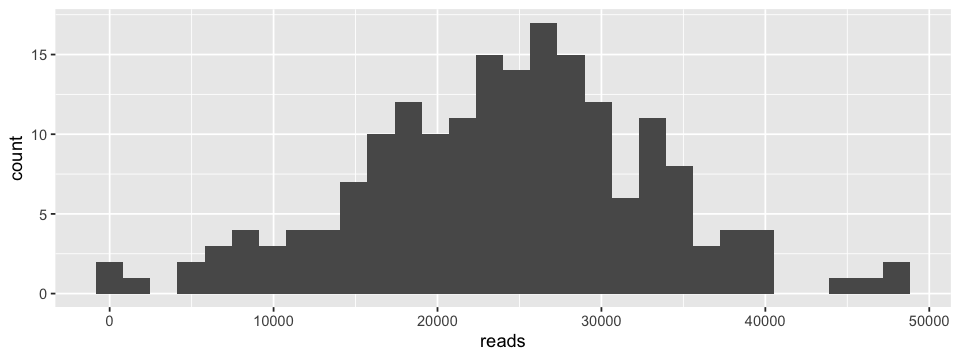

In [463]:
read_counts <- as.data.frame(rowSums(otu_table(ps_raw)))
colnames(read_counts) <- c('reads')

options(repr.plot.width = 8, repr.plot.height = 3)

ggplot(read_counts, aes(x=reads))+
    geom_histogram()

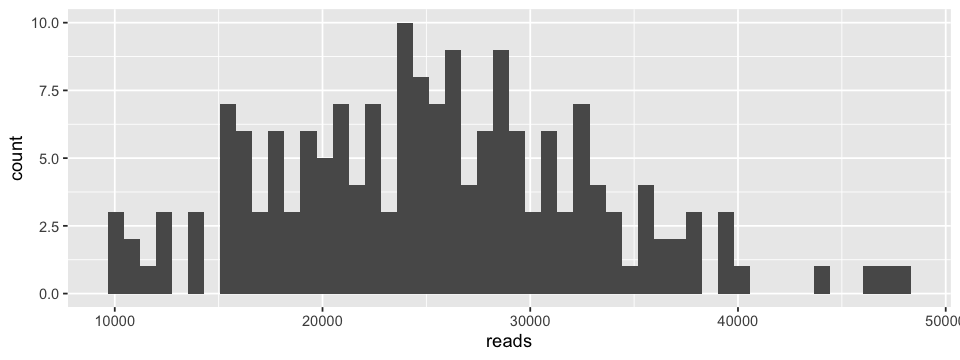

In [464]:
read_counts <- as.data.frame(rowSums(otu_table(ps)))
colnames(read_counts) <- c('reads')

options(repr.plot.width = 8, repr.plot.height = 3)

ggplot(read_counts, aes(x=reads))+
    geom_histogram(bins=50)

In [465]:
min(read_counts)

[1] 10131

# Number of ASVs per sample, including controls

In [466]:
sample_data(ps)$project_type <- factor(sample_data(ps)$project_type,
                                       levels=c('Experimental', 'ECAWPC', 'DPWF', 'Pipe_Loop', 'Full_Scale'))

Warning message in estimate_richness(physeq, split = TRUE, measures = measures):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”

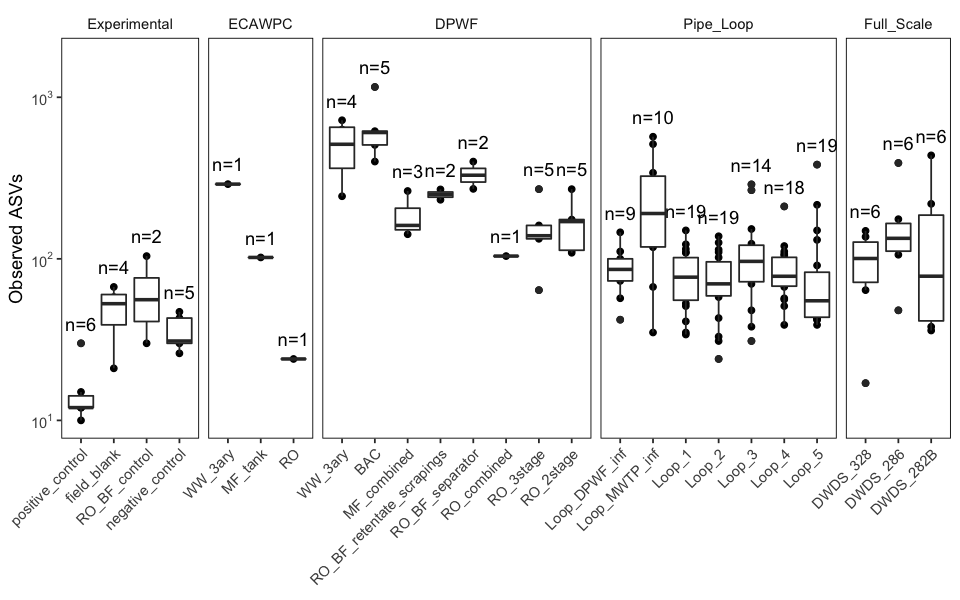

In [467]:
n_fun <- function(x){return(data.frame(y = max(x), label = paste0("n=",length(x))))}
#ps_bulk_sig <- subset_samples(ps_bulk_blank_sig, subset = Type %in% "Bulk")
options(repr.plot.width = 8, repr.plot.height = 5)
plot_richness(ps, x="location_code", measures=c("Observed"))+
    geom_boxplot()+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
     strip.background = element_blank(), 
    # strip.text.x = element_blank(),
     axis.title.x = element_blank(),
     axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))+
    ylab("Observed ASVs") +
    scale_y_continuous(trans="log10", limits=c(10,1800), labels=trans_format("log10", math_format(10^.x)))+
    stat_summary(fun.data = n_fun, geom = "text", vjust=-1)+
    #geom_vline(xintercept=4.5, linetype='solid')+
    #geom_vline(xintercept=12.5, linetype='solid')+
    #geom_vline(xintercept=19.5, linetype='solid')
    facet_grid(.~project_type, scale="free_x", space="free_x")

# Positive controls

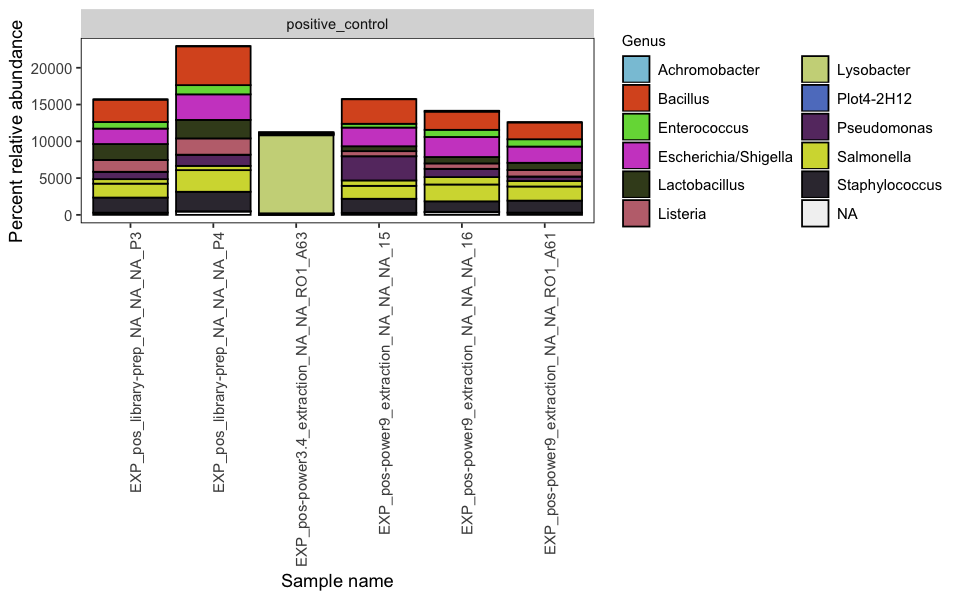

In [468]:
ps_mock <- subset_samples(ps, subset = location_code %in% c("positive_control"))
ps_mock <- filter_taxa(ps_mock, function(x) sum(x) > 10, TRUE) #keep only seqs that had reads in mock(s)
plot_bar(ps_mock, x="sample_code_full_and_batch", fill="Genus") + scale_fill_manual(values = colors) + 
  theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1, size=9),
        axis.text.y = element_text(size=9),
        legend.text=element_text(size=9), 
        legend.title=element_text(size=9))+
    facet_grid(.~location_code, scale="free_x", space="free_x")+
ylab("Percent relative abundance") +
xlab("Sample name")+
guides(fill=guide_legend(ncol=2))

In [469]:
#make table of mock sequences
ps_mock <- subset_samples(ps, subset = location_code %in% c("positive_control"))
ps_mock <- filter_taxa(ps_mock, function(x) sum(x) > 0, TRUE) #keep only seqs that had reads in mock(s)
mock_tax <- as.data.frame(tax_table(ps_mock))
mock_otu <- as.data.frame(otu_table(ps_mock))
mock_otu <- t(mock_otu)
mock_tab <- merge(mock_otu, mock_tax, by=0)
mock_tab <- mock_tab[order(-mock_tab$SD037), ]

In [470]:
# load reference sequences for mock controls and compare:
mock.ref <- getSequences("~/data/refs/ZymoBIOMICS.STD.refseq.v2/ssrRNAs/zymo_mock_16S_18S.fasta")
# identify matches to references, anything else is contamination
match.ref <- sapply(row.names(mock_otu), function(x) any(grepl(x, mock.ref)))
mock_contam <- row.names(as.data.frame(match.ref[match.ref==FALSE]))

In [471]:
#make table with just rows that are contaminants
mock_contam_tab <- mock_tab[mock_tab$Row.names %in% mock_contam, ]

In [472]:
#get only the ones that are found in two or more mocks with at least 1 read (consistent contamination)
mock_consistent_tax <- row.names(tax_table(filter_taxa(ps_mock, filterfun(kOverA(2, 1)), TRUE)))
mock_contam_tab[mock_contam_tab$Row.names %in% mock_consistent_tax,]

Row.names                                                                                                                                                                                                                                             
10 AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTCGAAACTGGCAGGCTTGAGTCTTGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACGAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACA
3  AGGGGGCTAGCGTTGCTCGGAATCACTGGGCGTAAAGGGCGCGTAGGCGGCCATTCAAGTCGGGGGTGAAAGCCTGTGGCTCAACCACAGAATTGCCTTCGATACTGTTTGGCTTGAGACCGGAAGAGGTAAGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCAGTGGCGAAGGCGGCTTACTGGTCCGGTTCTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA
20 AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTATATAAGACAGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTTGTGACTGTATAGCTAGAGTACGGCAGAGGGGGATGGAATTCCGCGTGTAGCAGTGAAATGCGTAGATATGCGGAGGAACACCGATGGCGAAGGCAATCCCCTGGGCCTGTACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA
22 AGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTTTGTTAAGTCTGATGTGAAAGCCCTGGGCTCAACCTGGGAATGGCATTGGAAACTGGCTTACTAGAGTGCGGTAGAGGGTAGCGGAATTCCCGGTGTAGCAGTGAAATGCGTAGATATCGGGAGGAACATCCGTGGCGAAGGCGGCTACCTGGACCAGCACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA
   SD037 SD039 SD049 SD119 SD150 SD167 Kingdom  Phylum        
10 610   745       0 1004  734   580   Bacteria Proteobacteria
3    2     0       2    0    2     4   Bacteria Proteobacteria
20   2     0       4    0    0     0   Bacteria Proteobacteria
22   0     0   10613    0    5     0   Bacteria Proteobacteria
   Class               Order                 Family             Genus     
10 Gammaproteobacteria Enterobacteriales     Enterobacteriaceae Salmonella
3  Alphaproteobacteria Rhizobiales           Beijerinckiaceae   Microvirga
20 Gammaproteobacteria Betaproteobacteriales Burkholderiaceae   Acidovorax
22 Gammaproteobacteria Xanthomonadales       Xanthomonadaceae   Lysobacter

In [473]:
samonella_additional <- as.character(mock_contam_tab[mock_contam_tab$Row.names %in% mock_consistent_tax,][1,1])
samonella_additional

[1] "AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTCGAAACTGGCAGGCTTGAGTCTTGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACGAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACA"

**There is a Salmonella enterica ASV (one mismatch) that isn't in the ref sequences and is abundant in all mock controls (except SD049, which failed).** Similarly, the Zymo mock community we sequenced with the El Paso study also had a Salmonella ASV that didn't match to the reference sequence (1 nt mismatch). It was a different one from this one though. Perhaps this is variable in Zymo's stock or there is error during PCR of this sequence (or sequencing error not corrected by DADA2).  This was also observed by Karsten et al. 2019.

In [474]:
# collect all mock taxa to remove them later
mock_taxa <- as.vector(mock_tab[1:10, 1])

# Negative controls

In [ ]:
# plot heatmap showing ASVs that are present in both negative controls and samples

In [475]:
ps
# normalize to percent
ps_perc <- transform_sample_counts(ps, function(OTU) 100*OTU/sum(OTU))


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7271 taxa and 174 samples ]
sample_data() Sample Data:       [ 174 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 7271 taxa by 6 taxonomic ranks ]

In [476]:
ps_samp <- subset_samples(ps, subset = !(location_code %in% c("negative_control",
                                                              "field_blank",
                                                              "RO_BF_control",
                                                              "positive_control")))
ps_samp <- filter_taxa(ps_samp, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0

ps_blank <- subset_samples(ps, subset = location_code %in% c("negative_control", "field_blank", "RO_BF_control"))
ps_blank <- filter_taxa(ps_blank, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0

#merge samples and blanks  back together and filter for only taxa that occur in at least one sample
ps_samp_blank <- merge_phyloseq(ps_samp, ps_blank)
ps_samp_blank <- filter_taxa(ps_samp_blank, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0

ps_samp_blank
ps_samp
ps_blank

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7050 taxa and 168 samples ]
sample_data() Sample Data:       [ 168 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 7050 taxa by 6 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6968 taxa and 156 samples ]
sample_data() Sample Data:       [ 156 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 6968 taxa by 6 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 265 taxa and 12 samples ]
sample_data() Sample Data:       [ 12 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 265 taxa by 6 taxonomic ranks ]

In [478]:
location_levels = c(
    'field_blank',
    'RO_BF_control',
    'negative_control',
    'WW_3ary',
    'BAC',
    'MF_combined',
    'MF_tank',
    'RO_BF_retentate_scrapings',
    'RO_BF_separator',
    'RO_combined',
    'RO_3stage', 'RO_2stage', 'RO',
    'Loop_DPWF_inf', 'Loop_MWTP_inf', 'Loop_1', 'Loop_2', 'Loop_3', 'Loop_4', 'Loop_5',
    'DWDS_328', 'DWDS_286', 'DWDS_282B')
sample_data(ps_samp_blank)$location_code <- factor(sample_data(ps_samp_blank)$location_code, 
                            levels=location_levels)


In [479]:
#for later: Get bulk-only taxa and intersecting taxa.

blank_taxa <- row.names(tax_table(ps_blank))
samp_taxa <- row.names(tax_table(ps_samp))
intersecting_taxa <- intersect(samp_taxa, blank_taxa)
samp_only_taxa <- setdiff(samp_taxa, intersecting_taxa)
blank_only_taxa <- setdiff(blank_taxa, intersecting_taxa)

ps_samp_only <- prune_taxa(samp_only_taxa, ps_samp_blank)
ps_intersecting <- prune_taxa(intersecting_taxa, ps_samp_blank)

ps_samp_and_intersecting <- prune_taxa(c(intersecting_taxa, samp_only_taxa), ps_samp_blank)
ps_samp_and_intersecting <- filter_taxa(ps_samp_and_intersecting, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0

In [480]:
length(blank_taxa)
length(samp_taxa)
length(intersecting_taxa)

[1] 265

[1] 6968

[1] 183

In [481]:
ps_samp_and_intersecting

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6968 taxa and 168 samples ]
sample_data() Sample Data:       [ 168 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 6968 taxa by 6 taxonomic ranks ]

In [482]:
# normalize to percent
#ps_samp_blank_perc <- transform_sample_counts(ps_samp_blank, function(OTU) 100*OTU/sum(OTU))
#
ps_intersecting_perc <- prune_taxa(intersecting_taxa, ps_perc)
ps_intersecting_perc <- filter_taxa(ps_intersecting_perc, function(x) sum(x) > 0, TRUE) #keep only seqs that had reads
ps_intersecting_perc_filt5 <- filter_taxa(ps_intersecting_perc, filterfun(kOverA(2, 5)), TRUE)
ps_intersecting_perc_filt2 <- filter_taxa(ps_intersecting_perc, filterfun(kOverA(2, 2)), TRUE)
ps_intersecting_perc_filt1 <- filter_taxa(ps_intersecting_perc, filterfun(kOverA(2, 1)), TRUE)

#ps_blank_perc <- prune_taxa(blank_taxa, ps_samp_blank_perc)
#ps_blank_perc <- filter_taxa(ps_blank_perc, function(x) sum(x) > 0, TRUE) #keep only seqs that had reads
#ps_blank_perc_filt2 <- filter_taxa(ps_blank_perc, filterfun(kOverA(2, 2)), TRUE)
#ps_blank_perc_filt1 <- filter_taxa(ps_blank_perc, filterfun(kOverA(2, 1)), TRUE)


In [483]:
ps_intersecting_perc_filt2
ps_intersecting_perc_filt5

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 53 taxa and 174 samples ]
sample_data() Sample Data:       [ 174 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 53 taxa by 6 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 40 taxa and 174 samples ]
sample_data() Sample Data:       [ 174 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 40 taxa by 6 taxonomic ranks ]

**Major contaminants are clostridiaceae_1, peptostreptococcaceae, and Family XI, Xanthomonadaceae**

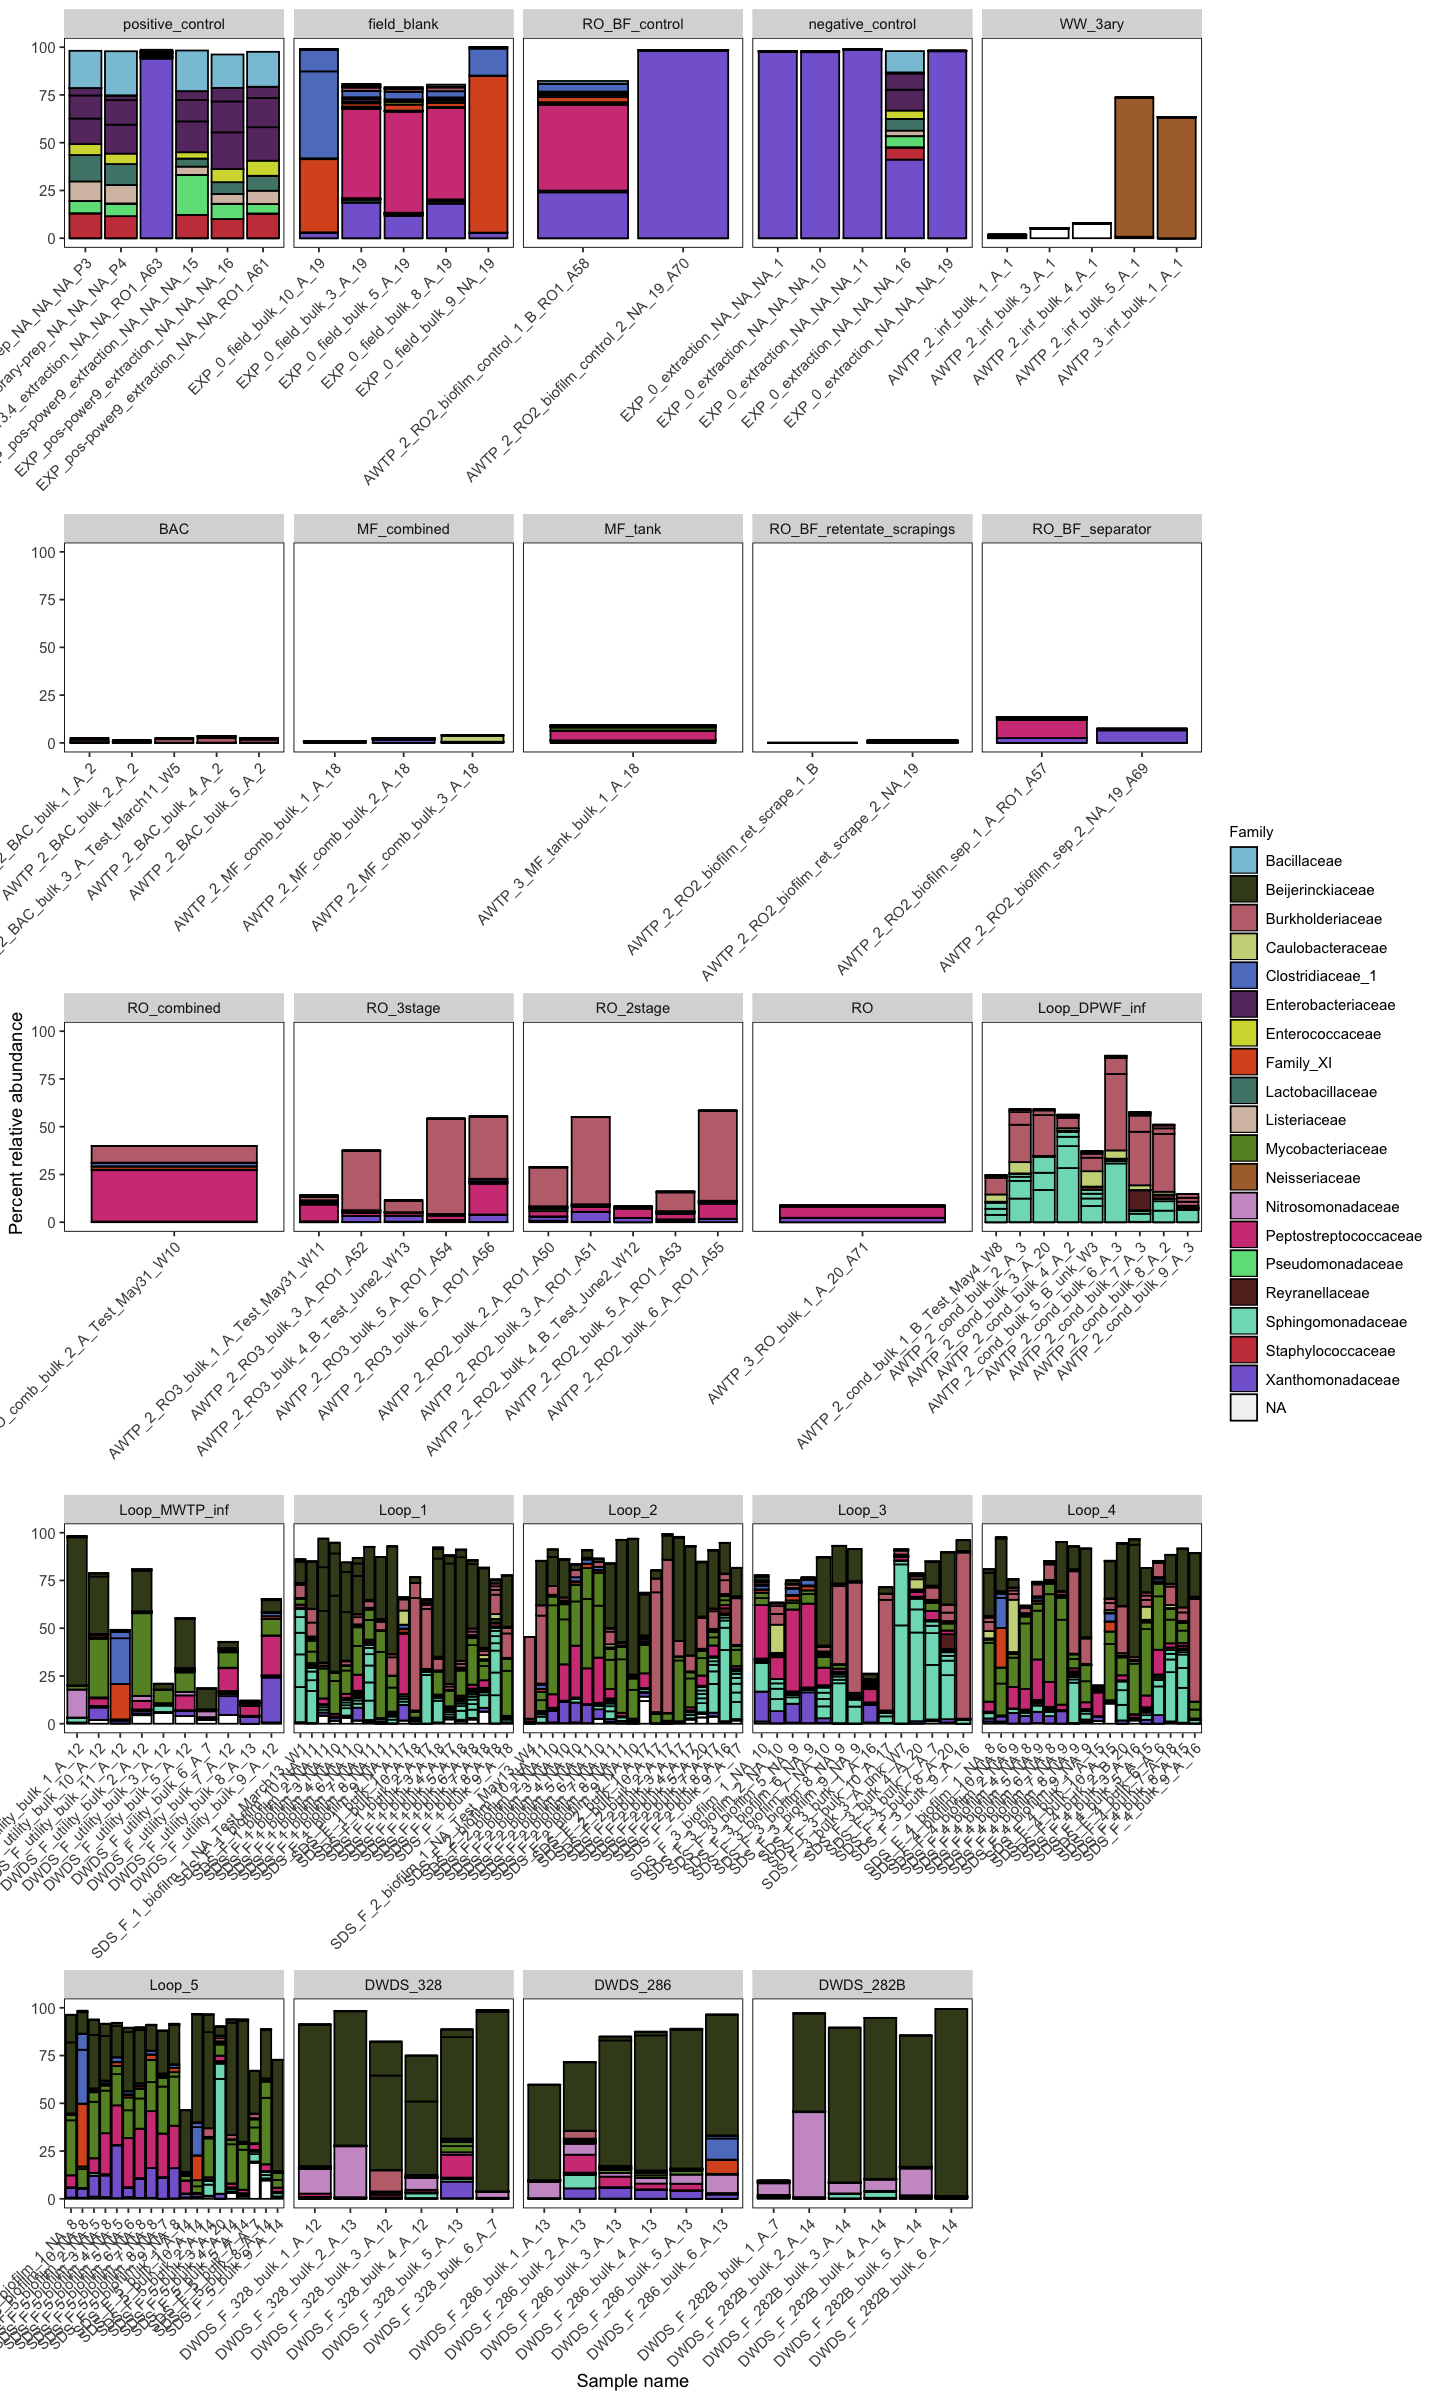

In [484]:
options(repr.plot.width = 12, repr.plot.height = 20)
#playing with the colors a bit:
colors2 <- colors[-c(2,3,4)]
colors2[8] <- colors[2]

plot_bar(ps_intersecting_perc_filt5, x="sample_code_full_and_batch", fill="Family") + scale_fill_manual(values = colors2) + 
  theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9),
        axis.text.y = element_text(size=9),
        legend.text=element_text(size=9), 
        legend.title=element_text(size=9))+
    facet_wrap(~location_code, nrow=5, scale="free_x")+
ylab("Percent relative abundance") +
xlab("Sample name")+
guides(fill=guide_legend(ncol=1))


Warning message:
“Transformation introduced infinite values in discrete y-axis”

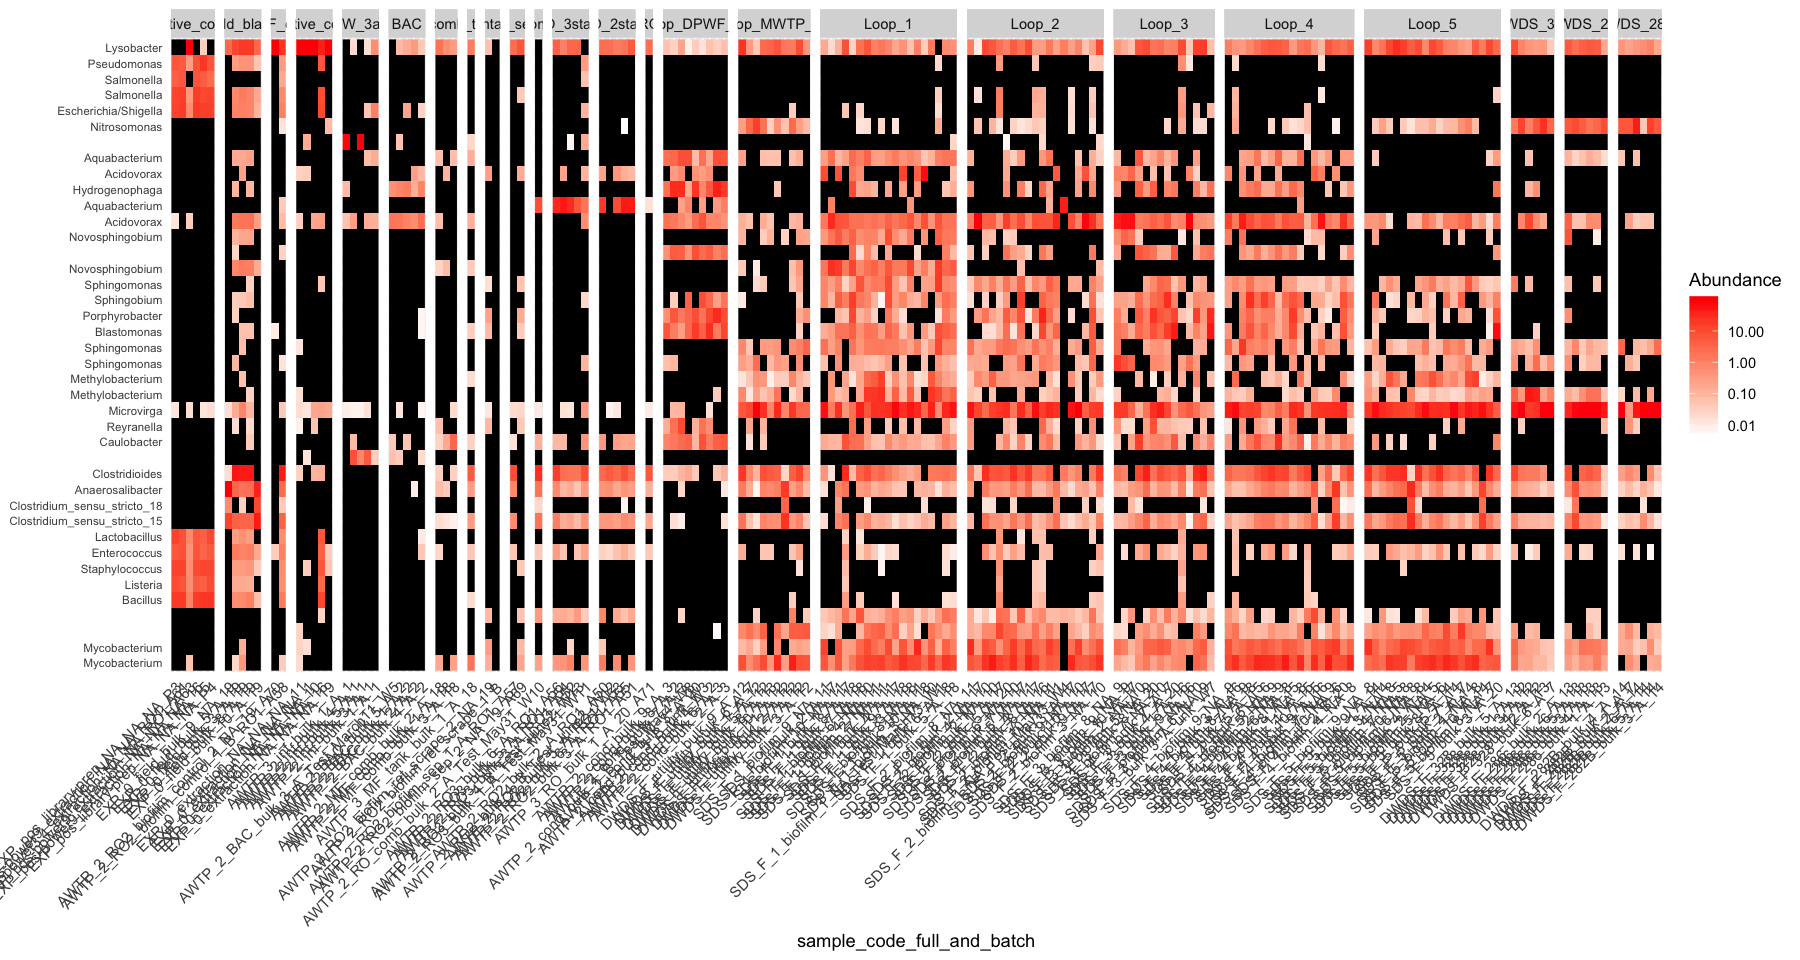

In [485]:
#plot heatmap
options(repr.plot.width = 15, repr.plot.height = 8)
plot_heatmap(ps_intersecting_perc_filt5, taxa.label = "Genus", sample.label = "sample_code_full_and_batch", sample.order = "location_code", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~location_code, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_intersction_samples_blanks_gr5reads_genus.png', device='png', width=24, height=9)

In [486]:
#Define low biomass samples
ps_samp_blank.lowBM <- subset_samples(ps_samp_blank, subset = !(location_code %in% c("WW_3ary",
                                                                                     "BAC",
                                                                                     "RO_BF_retentate_scrapings",
                                                                                     "MF_tank",
                                                                                     "MF_combined",
                                                                                     "Loop_DPWF_inf")))

In [452]:
unique(sample_data(ps_samp_blank)$location_code)

[1] Loop_MWTP_inf             Loop_5                   
 [3] DWDS_328                  RO_BF_separator          
 [5] MF_tank                   MF_combined              
 [7] Loop_4                    Loop_3                   
 [9] DWDS_282B                 Loop_2                   
[11] Loop_DPWF_inf             BAC                      
[13] RO_BF_retentate_scrapings Loop_1                   
[15] WW_3ary                   RO_combined              
[17] RO_3stage                 RO_2stage                
[19] DWDS_286                  RO                       
[21] field_blank               negative_control         
[23] RO_BF_control            
23 Levels: field_blank RO_BF_control negative_control WW_3ary ... DWDS_282B

In [ ]:
#Cross-contamination coming from positive control into samples/blanks

Warning message:
“Transformation introduced infinite values in discrete y-axis”

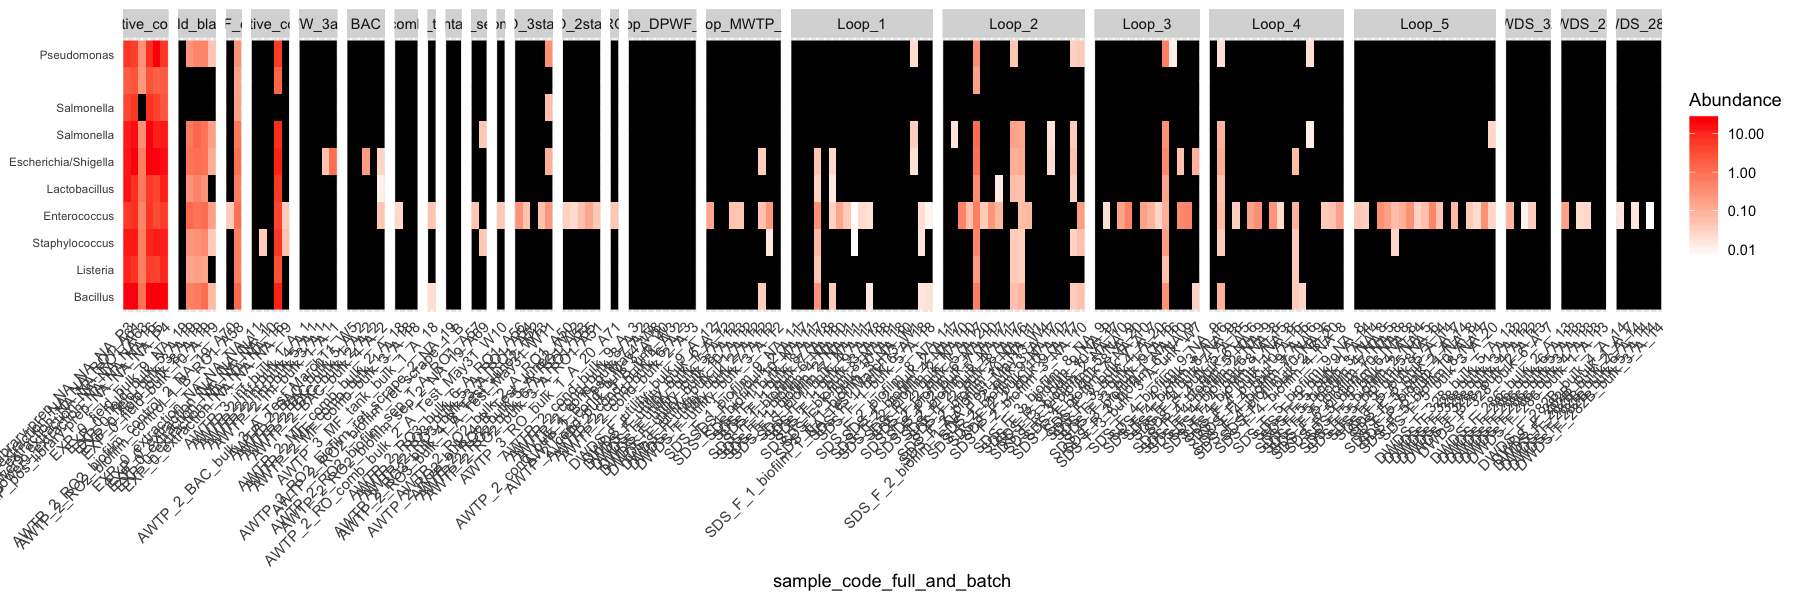

In [487]:
ps_mock_in_all_perc <- prune_taxa(mock_taxa, ps_perc)

#plot heatmap
options(repr.plot.width = 15, repr.plot.height = 5)
plot_heatmap(ps_mock_in_all_perc, taxa.label = "Genus", sample.label = "sample_code_full_and_batch", sample.order = "location_code", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~location_code, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_mock_in_all.png', device='png', width=20, height=4)

In [366]:
ps_mock_in_all_perc
mockinall_tax <- as.data.frame(tax_table(ps_mock_in_all_perc))
mockinall_otu <- as.data.frame(otu_table(ps_mock_in_all_perc))
mockinall_otu <- t(mockinall_otu)
mockinall_tab <- merge(mockinall_otu, mockinall_tax, by=0)

#t(mockinall_tab)
#write.table(mockinall_tab, '~/data/awtp2_16S/mock_taxa_all_samples_perc.tsv', sep='\t', quote = FALSE, row.names=FALSE)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 10 taxa and 183 samples ]
sample_data() Sample Data:       [ 183 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 10 taxa by 6 taxonomic ranks ]

### Remove mock taxa from dataset (including the E. facaelis that is present in some samples)

In [368]:
allTaxa = taxa_names(ps_samp_blank)
allTaxa_minus_mock <- allTaxa[!(allTaxa %in% mock_taxa)]
ps_samp_blank <- subset_samples(ps_samp_blank, subset = !(location_code %in% c("positive_control")))
ps_samp_blank <- prune_taxa(allTaxa_minus_mock, ps_samp_blank)
ps_samp_blank

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7113 taxa and 176 samples ]
sample_data() Sample Data:       [ 176 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 7113 taxa by 6 taxonomic ranks ]

### Remove PCR negative control that is contaminated with mock taxa

In [459]:
#EXP_0_extraction_NA_NA_NA_16 = SD108 <- contaminated with mock taxa
#EXP_0_extraction_NA_NA_NA_4  <- contaminated with something else
ps_samp_blank <- subset_samples(ps_samp_blank, subset = !(sample_code_full_and_batch %in% c("EXP_0_extraction_NA_NA_NA_16",
                                                                                            "EXP_0_extraction_NA_NA_NA_4")))


In [460]:
ps_blank <- subset_samples(ps, subset = location_code %in% c("negative_control", "field_blank", "RO_BF_control"))
ps_blank <- filter_taxa(ps_blank, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0
ps_blank

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 371 taxa and 18 samples ]
sample_data() Sample Data:       [ 18 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 371 taxa by 6 taxonomic ranks ]

## Examine readcounts of blanks

In [434]:
read_counts_blanks <- as.data.frame(rowSums(otu_table(ps_blank)))
read_counts_blanks

rowSums(otu_table(ps_blank))
SD001 17493                       
SD002 37828                       
SD044 23887                       
SD045 21184                       
SD106  5382                       
SD107 11130                       
SD108 10898                       
SD109 13638                       
SD110  8207                       
SD111  8161                       
SD112 16348                       
SD113 10403                       
SD115  5615                       
SD116 10315                       
SD117 10131                       
SD118  6212                       
SD120  7756                       
SD176 30303

# Temp decontamination of top 2

In [416]:
contaminants <-  c('AGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTTTGTTAAGTCTGATGTGAAAGCCCTGGGCTCAACCTGGGAATGGCATTGGAAACTGGCTTACTAGAGTGCGGTAGAGGGTAGCGGAATTCCCGGTGTAGCAGTGAAATGCGTAGATATCGGGAGGAACATCCGTGGCGAAGGCGGCTACCTGGACCAGCACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA',
                   'AGGTGGCAAGCGTTGTCCGGATTTACTGGGCGTAAAGGGTGCGTAGGCGGATGCTTAAGTGAGATGTGAAATACCTAGGCTTAACTTAGGGGCTGCATTTCAAACTGGGCATCTAGAGTACAGGAGAGGGAAACGGAATTCCTAGTGTAGCGGTGAAATGCGTAGAGATTAGGAAGAACACCAGTGGCGAAGGCGGTTTCCTGGACTGTAACTGACGCTGAGGCACGAAAGCGTGGGTAGCAAACA')

allTaxa = taxa_names(ps_samp_blank)
allTaxa_minus_contam <- allTaxa[!(allTaxa %in% contaminants)]
ps_samp_blank_temp_decontam <- prune_taxa(allTaxa_minus_contam, ps_samp_blank)

ps_samp_blank_temp_decontam_perc <- transform_sample_counts(ps_samp_blank_temp_decontam,
                                                            function(OTU) 100*OTU/sum(OTU))

# Using Decontam

Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”

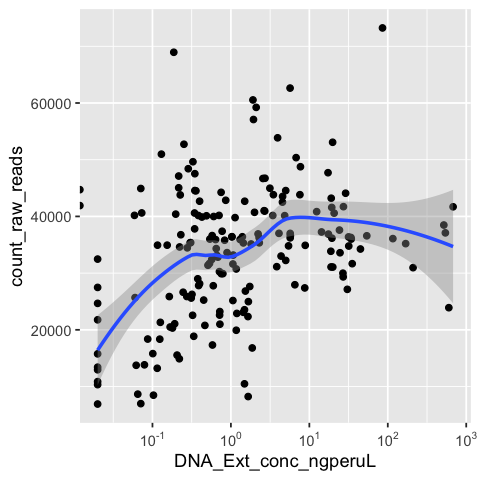

In [426]:
options(repr.plot.width = 4, repr.plot.height = 4)

ggplot(sample_data(ps), aes(x=DNA_Ext_conc_ngperuL, y=count_raw_reads))+
    geom_point()+
    scale_x_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x))) + 
    geom_smooth(method = loess) 
    #scale_y_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x)))


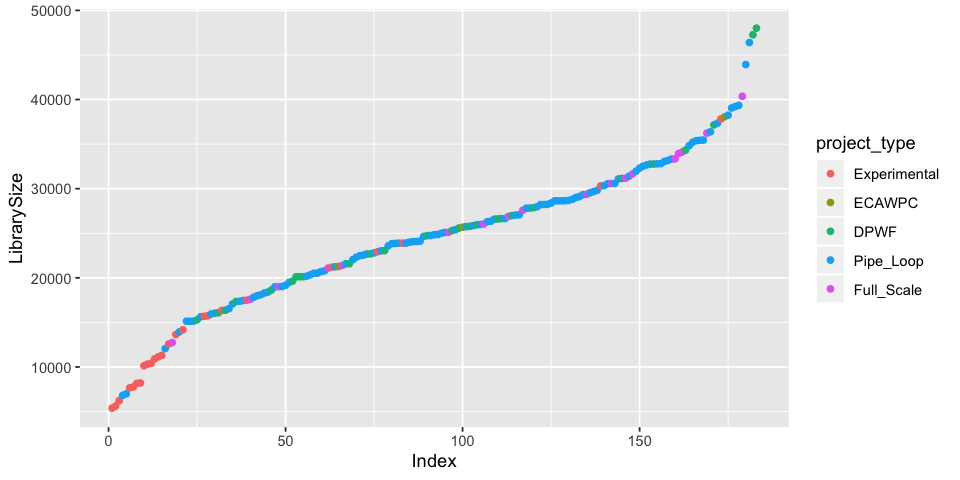

In [240]:
df <- as.data.frame(sample_data(ps)) # Put sample_data into a ggplot-friendly data.frame
df$LibrarySize <- sample_sums(ps)
df <- df[order(df$LibrarySize),]
df$Index <- seq(nrow(df))

options(repr.plot.width = 8, repr.plot.height = 4)

ggplot(data=df, aes(x=Index, y=LibrarySize, color=project_type)) + geom_point()


## Frequency method

In [442]:
contamdf.freq <- isContaminant(ps_samp, method="frequency", conc="DNA_Ext_conc_ngperuL")

In [443]:
head(contamdf.freq)

freq       
AGGGGGCTAGCGTTGCTCGGAATCACTGGGCGTAAAGGGCGCGTAGGCGGCCATTCAAGTCGGGGGTGAAAGCCTGTGGCTCAACCACAGAATTGCCTTCGATACTGTTTGGCTTGAGACCGGAAGAGGTAAGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCAGTGGCGAAGGCGGCTTACTGGTCCGGTTCTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA 0.211343299
AGGGTCCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTAGAGTACTGCAGGGGAGACTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAGCGAAAGCGTGGGTAGCGAACA 0.004140335
AGGGTGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTAGAGTACTGCAGGGGAGACTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACA 0.080015705
AGGGTCCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTTGAGTACTGCAGGGGAGACTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACA 0.001434974
AGGGGGCTAGCGTTATCCGGATTTACTGGGCGTAAAGGGTGCGTAGGCGGTCTTTCAAGTCAGGAGTGAAAGGCTACGGCTCAACCGTAGTAAGCTCTTGAAACTGGGAGACTTGAGTGCAGGAGAGGAGAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTAGCGAAGGCGGCTCTCTGGACTGTAACTGACGCTGAGGCACGAAAGCGTGGGGAGCGAACAG 0.055666960
AGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTTTGTTAAGTCTGATGTGAAAGCCCTGGGCTCAACCTGGGAATGGCATTGGAAACTGGCTTACTAGAGTGCGGTAGAGGGTAGCGGAATTCCCGGTGTAGCAGTGAAATGCGTAGATATCGGGAGGAACATCCGTGGCGAAGGCGGCTACCTGGACCAGCACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA 0.028645518
                                                                                                                                                                                                                                                       prev
AGGGGGCTAGCGTTGCTCGGAATCACTGGGCGTAAAGGGCGCGTAGGCGGCCATTCAAGTCGGGGGTGAAAGCCTGTGGCTCAACCACAGAATTGCCTTCGATACTGTTTGGCTTGAGACCGGAAGAGGTAAGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCAGTGGCGAAGGCGGCTTACTGGTCCGGTTCTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA 138 
AGGGTCCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTAGAGTACTGCAGGGGAGACTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAGCGAAAGCGTGGGTAGCGAACA  94 
AGGGTGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTAGAGTACTGCAGGGGAGACTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACA 128 
AGGGTCCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTTGAGTACTGCAGGGGAGACTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACA  25 
AGGGGGCTAGCGTTATCCGGATTTACTGGGCGTAAAGGGTGCGTAGGCGGTCTTTCAAGTCAGGAGTGAAAGGCTACGGCTCAACCGTAGTAAGCTCTTGAAACTGGGAGACTTGAGTGCAGGAGAGGAGAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTAGCGAAGGCGGCTCTCTGGACTGTAACTGACGCTGAGGCACGAAAGCGTGGGGAGCGAACAG 132 
AGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTTTGTTAAGTCTGATGTGAAAGCCCTGGGCTCAACCTGGGAATGGCATTGGAAACTGGCTTACTAGAGTGCGGTAGAGGGTAGCGGAATTCCCGGTGTAGCAGTGAAATGCGTAGATATCGGGAGGAACATCCGTGGCGAAGGCGGCTACCTGGACCAGCACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA 151 
                                                                                                                                                                                                                                                       p.freq     
AGGGGGCTAGCGTTGCTCGGAATCACTGGGCGTAAAGGGCGCGTAGGCGGCCATTCAAGTCGGGGGTGAAAGCCTGTGGCTCAACCACAGAATTGCCTTCGATACTGTTTGGCTTGAGACCGGAAGAGGTAAGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCAGTGGCGAAGGCGGCTTACTGGTCCGGTTCTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA 0.891762104
AGGGTCCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTAGAGTACTGCAGGGGAGACTGGAATTCCTGGTGTAGCG

In [444]:
table(contamdf.freq$contaminant)
head(which(contamdf.freq$contaminant))


FALSE  TRUE 
 6896    78 

[1]   5   6  26 115 469 583

In [445]:
decontam_freq_contams <- row.names(contamdf.freq[contamdf.freq$contaminant==TRUE,])

In [446]:
intersect(decontam_freq_contams, intersecting_taxa)

[1] "AGGGGGCTAGCGTTATCCGGATTTACTGGGCGTAAAGGGTGCGTAGGCGGTCTTTCAAGTCAGGAGTGAAAGGCTACGGCTCAACCGTAGTAAGCTCTTGAAACTGGGAGACTTGAGTGCAGGAGAGGAGAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTAGCGAAGGCGGCTCTCTGGACTGTAACTGACGCTGAGGCACGAAAGCGTGGGGAGCGAACAG"
[2] "AGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTTTGTTAAGTCTGATGTGAAAGCCCTGGGCTCAACCTGGGAATGGCATTGGAAACTGGCTTACTAGAGTGCGGTAGAGGGTAGCGGAATTCCCGGTGTAGCAGTGAAATGCGTAGATATCGGGAGGAACATCCGTGGCGAAGGCGGCTACCTGGACCAGCACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA"
[3] "AGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGGGTGCGTAGGTGGTTGAATGAGTTATCTGTGAAATTCCTGGGCTTAACCTGGGGTGGTCAGATGATACTGTTTGACTCGAGTATGGGAGAGGGTAGTAGAATTTCCGGTGTAGCGGTGAAATGCGTAGAGATCGGAAGGAACACCGGTGGCGAAGGCGGCTACCTGGCCTGATACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA"
[4] "ATGTGGCAAGCGTTGTTCGGAATCACTGGGCGTAAAGAATGCGTAGGCGGCTTGACAAGTCAGGAGTGAAATCCCCAGGCTCAACCTGGGAACTGCTTTTGAAACTGTCTTGCTAGAGTCCCGGAGGGGTTGGCGGAATTCCGAGTGTAGAGGTGGAATTCGCAGATATTCGGAGGAACACCAGTGGCGTAGGCGGCCAACTGGACGGGAACTGACGCTGAGGCATGAAAGTGTGGGGAGCAAACA"

**The decontam frequency method identified just 4 of the same ASVs as were identified by the intersection of negative controls and samples.**

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 1 rows containing missing values (geom_path).”

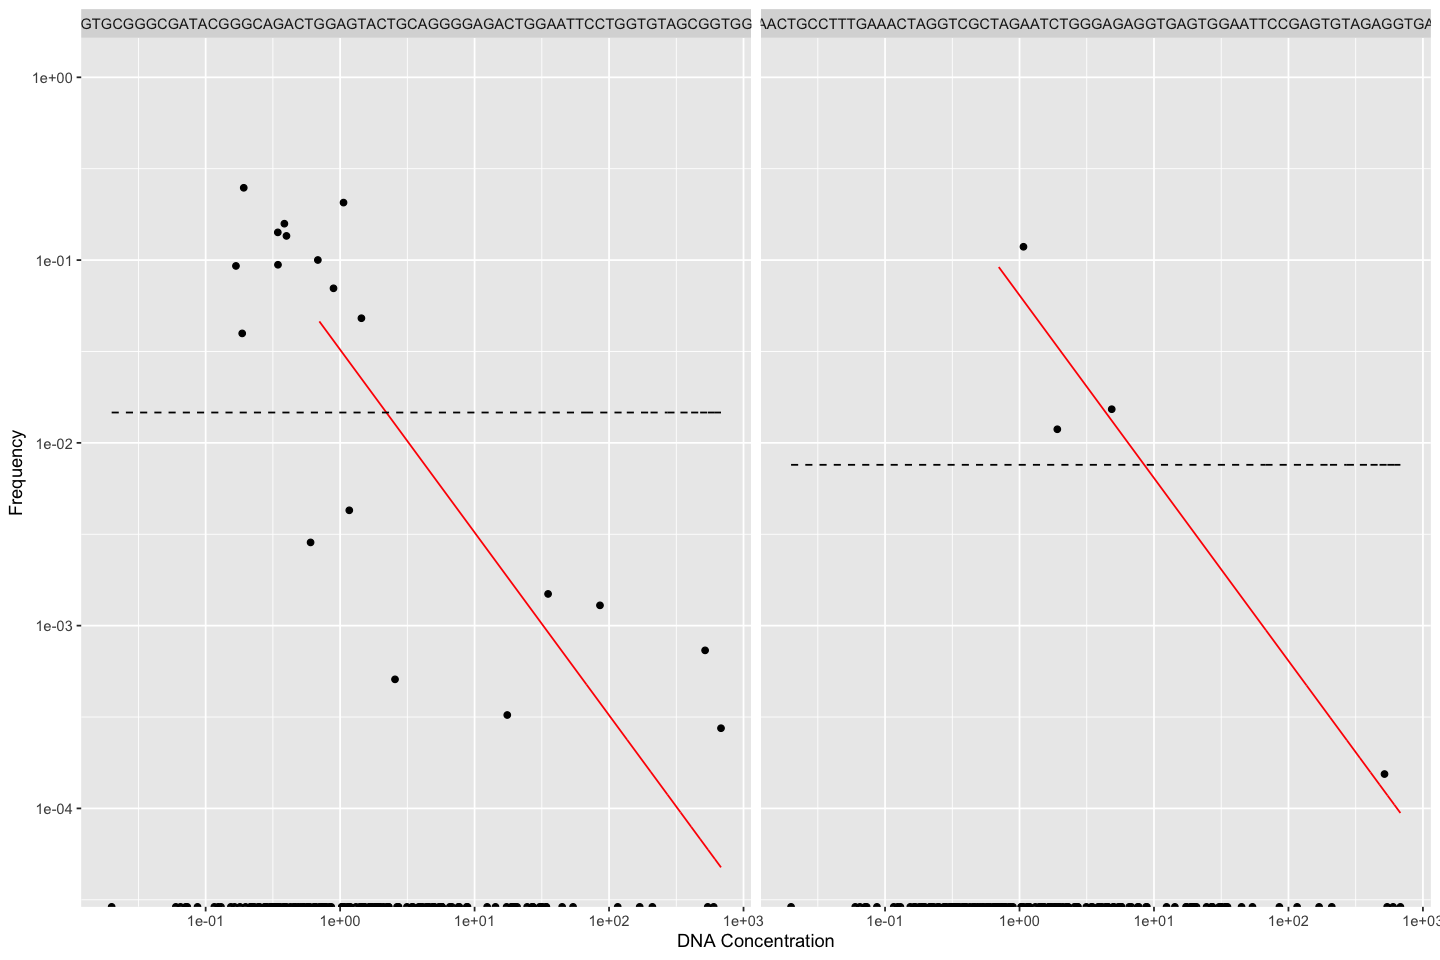

In [447]:
# expected contaminants should follow the red line
plot_frequency(ps_samp, taxa_names(ps_samp)[c(26,115)], conc="DNA_Ext_conc_ngperuL") + 
  xlab("DNA Concentration")


Warning message:
“Transformation introduced infinite values in discrete y-axis”Warning message:
“Transformation introduced infinite values in discrete y-axis”

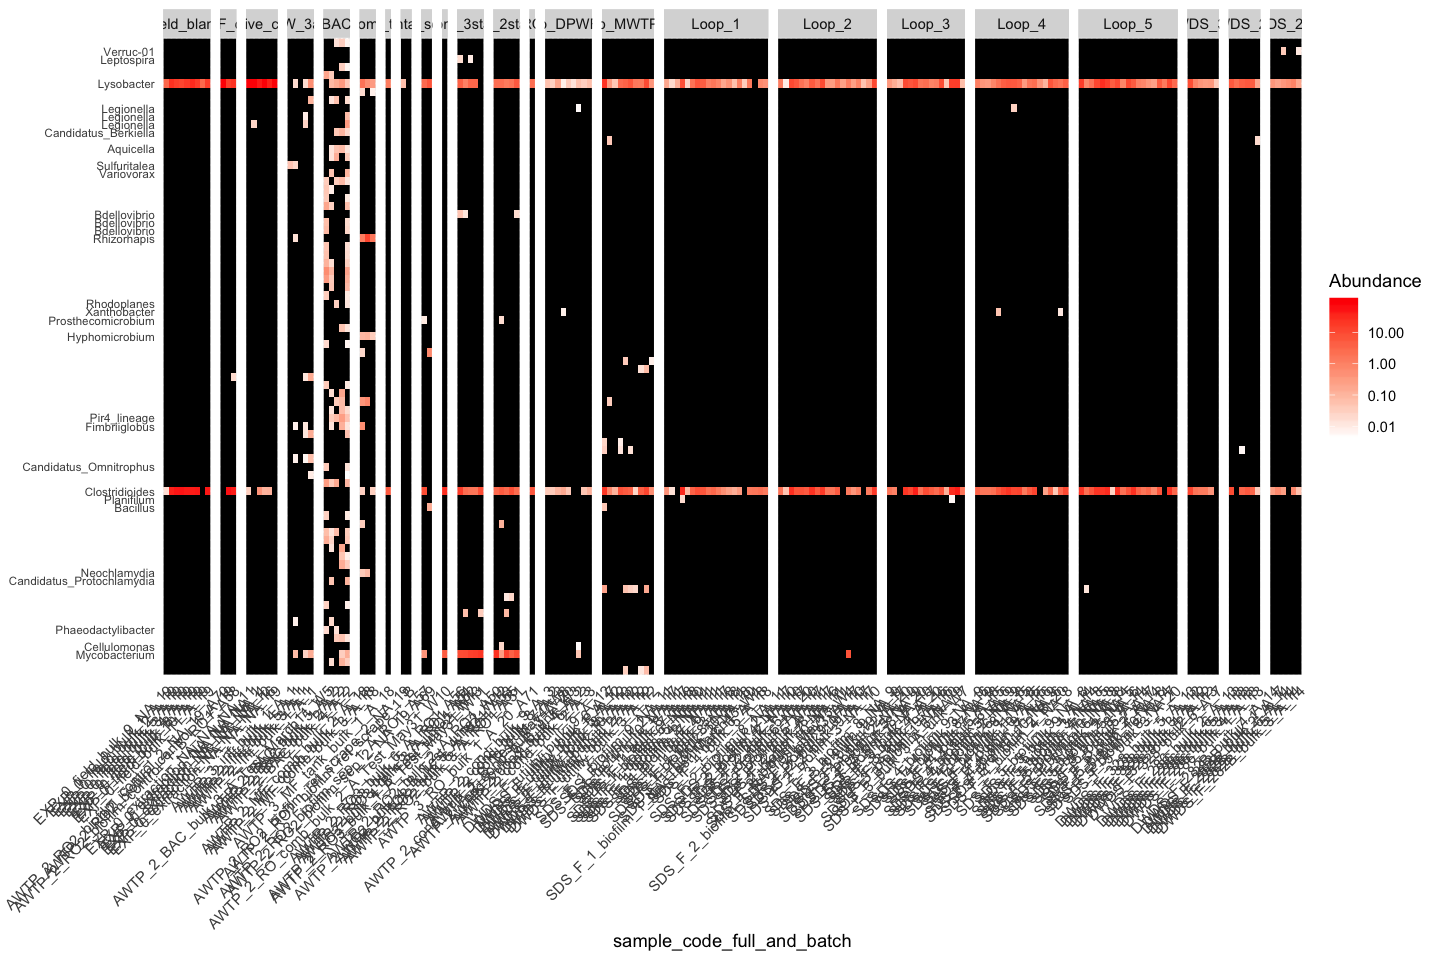

In [448]:
ps_decontam_freq_contams <- prune_taxa(decontam_freq_contams, ps_samp_blank_perc)
sample_data(ps_decontam_freq_contams)$location_code <- factor(sample_data(ps_decontam_freq_contams)$location_code, 
                            levels=location_levels)

#plot heatmap
options(repr.plot.width = 12, repr.plot.height = 8)
plot_heatmap(ps_decontam_freq_contams, taxa.label = "Genus", sample.label = "sample_code_full_and_batch", sample.order = "location_code", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~location_code, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_decontam_freq_contams.png', device='png', width=20, height=9)

**This method yielded 2 real-looking contaminants, but the high biomass and distinct community in BAC and some WW samples is a confounding factor in the analysis**

### Decontaminate using frequency after removing confounding high-biomass samples (WW and BAC, RO retentate scrapings)

In [399]:
ps_samp_blank.lowBM <- subset_samples(ps_samp_blank, subset = !(location_code %in% c("WW_3ary",
                                                                               "BAC",
                                                                               "RO_BF_retentate_scrapings")))
ps_samp_blank.lowBM <- filter_taxa(ps_samp_blank.lowBM, function(x) sum(x) > 0, TRUE) #keep only seqs that had reads
ps_samp_blank.lowBM

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4434 taxa and 164 samples ]
sample_data() Sample Data:       [ 164 samples by 23 sample variables ]
tax_table()   Taxonomy Table:    [ 4434 taxa by 6 taxonomic ranks ]

In [400]:
contamdf.freq.lowBM <- isContaminant(ps_samp_blank.lowBM, method="frequency", conc="DNA_Ext_conc_ngperuL")

In [401]:
table(contamdf.freq.lowBM$contaminant)


FALSE  TRUE 
 4399    35 

In [402]:
decontam_freq_contams.lowBM <- row.names(contamdf.freq.lowBM[contamdf.freq.lowBM$contaminant==TRUE,])

Warning message:
“Transformation introduced infinite values in discrete y-axis”Warning message:
“Transformation introduced infinite values in discrete y-axis”

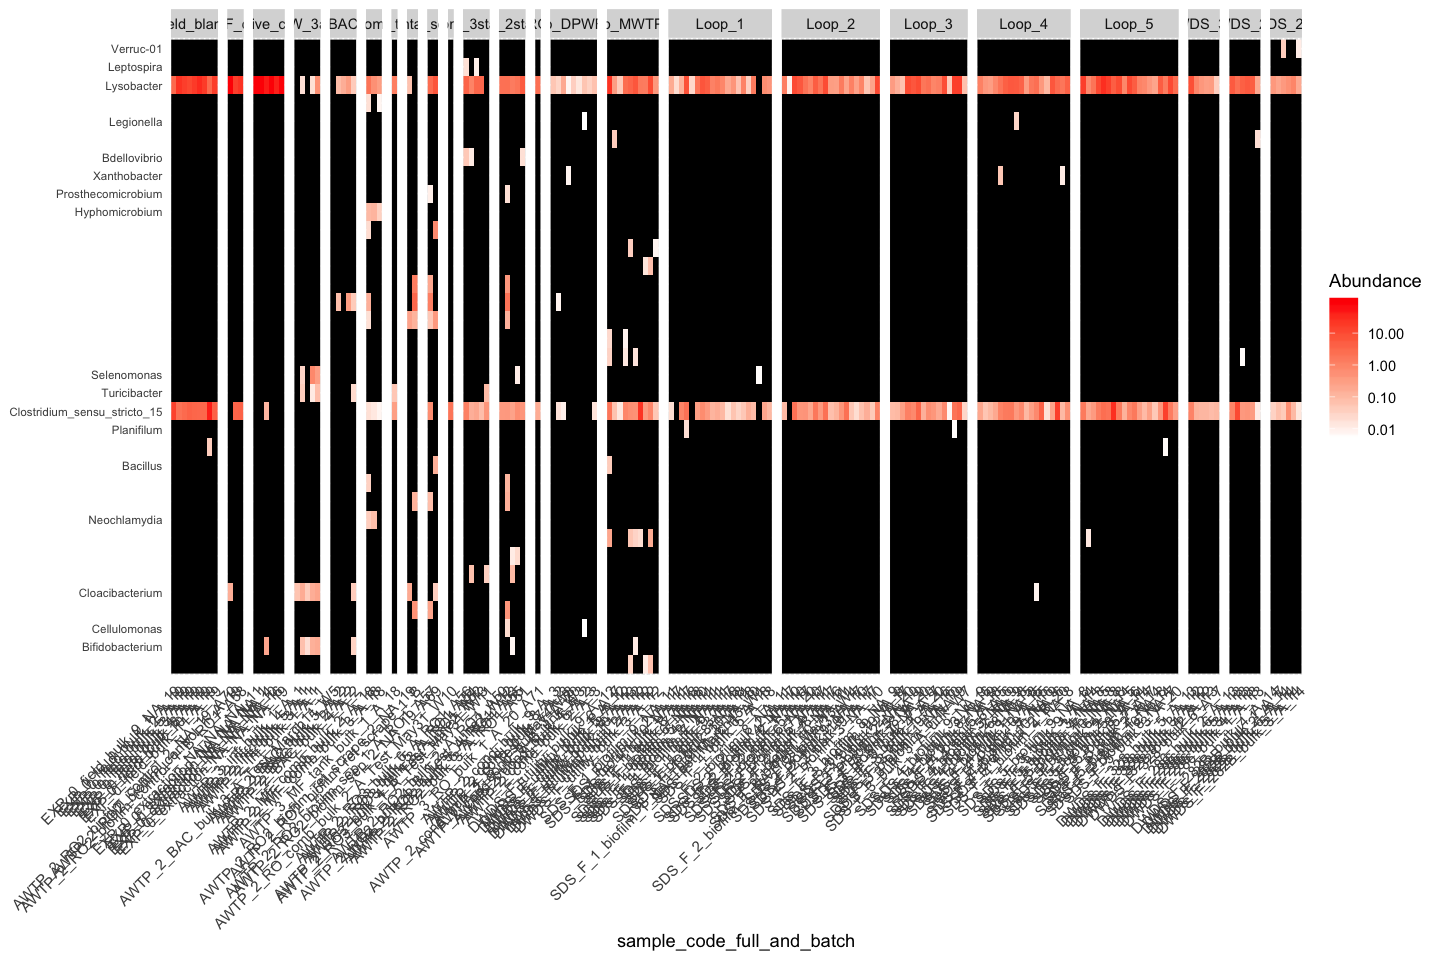

In [403]:
ps_decontam_freq_contams.lowBM <- prune_taxa(decontam_freq_contams.lowBM, ps_samp_blank_perc)
sample_data(ps_decontam_freq_contams.lowBM)$location_code <- factor(sample_data(ps_decontam_freq_contams.lowBM)$location_code, 
                            levels=location_levels)

#plot heatmap
options(repr.plot.width = 12, repr.plot.height = 8)
plot_heatmap(ps_decontam_freq_contams.lowBM, taxa.label = "Genus", sample.label = "sample_code_full_and_batch", sample.order = "location_code", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~location_code, scale="free_x", space="free_x")
ggsave('~/data/awtp2_16S/heatmap_decontam_freq_contams_lowBM.png', device='png', width=20, height=9)

In [415]:
tax_table(ps_decontam_freq_contams.lowBM)

Kingdom 
AGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTTTGTTAAGTCTGATGTGAAAGCCCTGGGCTCAACCTGGGAATGGCATTGGAAACTGGCTTACTAGAGTGCGGTAGAGGGTAGCGGAATTCCCGGTGTAGCAGTGAAATGCGTAGATATCGGGAGGAACATCCGTGGCGAAGGCGGCTACCTGGACCAGCACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA Bacteria
AGGTGGCAAGCGTTGTCCGGATTTACTGGGCGTAAAGGGTGCGTAGGCGGATGCTTAAGTGAGATGTGAAATACCTAGGCTTAACTTAGGGGCTGCATTTCAAACTGGGCATCTAGAGTACAGGAGAGGGAAACGGAATTCCTAGTGTAGCGGTGAAATGCGTAGAGATTAGGAAGAACACCAGTGGCGAAGGCGGTTTCCTGGACTGTAACTGACGCTGAGGCACGAAAGCGTGGGTAGCAAACA Bacteria
ACTGCGCGAACGTTATTCGGAATCACTGGGCTTACAGGGTGCGTAGGTGGCATCGAAAGTAGGGTGTGAAATGCCTTGGCTCAACCAAGGCACAGCGCTCTAAACTACTTTGCTTGAGTGAGTCAGGGGTGCACGGAACTTCCGGTGGAGCGGTGAAATGTGTTGATATCGGAAGGAACACCGGCGGCGAAAGCGGTGCACTGGGGCTTAACTGACACTGAGGCACGAAAGCCAGGGGAGCGAACG Bacteria
ACCGTGCGAACGTTATTCGGAATCACTGGGCTTAAAGCGCGTGTAGGCGGCCCGGCACGTCATTGGCTGAAATCCCCTAGCTCAACTAGGGAAGTGGCCGTGATACGACCGGGCTGGAGGGGGGTAGGGGGGACGGGAACTCACGGTGGAGCGGTGAAATGCGTTGAGATCGTGAGGAACGCCCGCGGCGAAAGCGCGTCCCTGGACCCCACCTGACGCTGAGACGCGAAAGCCAGGGGAGCGAAC Bacteria
ACTGTGCGAACGTTATTCGGATTCACTGGGCTTACAGGGTGCGTAGGCGGCTTGCTAAGTAGGGTGTGAAAGCCCCCGGCTTAACCGGGGAATGGCGCCCTAAACTGGCGAGCTGGAGTGAGATAGGGGTGTGCGGAACTTCCGGTGGAGCGGTGAAATGTGTTGATATCGGAAGGAACGCCGGTGGCGAAAGCGGCACACTGGATCTCAACTGACGCTGAGGCACGAAAGCCAGGGGAGCGAACG Bacteria
AGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGGGAGCGCAGGCGGGAAGGTAAGTCGGTCTTAAAAGTGCGGGGCTCAACCCCGTGATGGGATCGAAACTATCTTTCTTGAGTGCAGGAGAGGAAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGACTTTCTGGACTGTAACTGACGCTGAGGCTCGAAAGCCAGGGGAGCGAACGG Bacteria
AGGGTGCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTCCGTAGGCGGACTTATAAGTCAGTGGTGAAAGCCTGTCGCTTAACGATAGAACTGCCATTGATACTGTAAGTCTTGAGTATATTTGAGGTAGCTGGAATAAGTAGTGTAGCGGTGAAATGCATAGATATTACTTAGAACACCAATTGCGAAGGCAGGTTACCAAGATATAACTGACGCTGAGGGACGAAAGCGTGGGGAGCGAACA Bacteria
AGGGAGCAAGCGTTGTCCGGAATCATTGGGCGTAAAGCGCGCGTAGGTGGCCACATAAGTCCGTTGTGAAAGTCAAAGGCTCAACCTTTGAAAGCCGATGGATACTGTGTGGCTAGAGTACGGAAGAGGCGAGTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCAATAGCGAAGGCAGCTCGCTGGGACGTTACTGACACTGAGGCGCGAAAGCGTGGGGAGCGAACA Bacteria
AGGGGGCTAGCGTTGTTCGGAATGACTGGGCGTAAAGGGCGCGTAGGCGGCGATTTTAGTCAGGCGTGAAAGCCCTGGGCTTAACCTAGGAACTGCGTTTGATACTGGATCGCTTGAGTGTGGGAGAGGATGGTGGAATTCCCAGTGTAGAGGTGAAATTCGTAGATATTGGGAAGAACACCGGTGGCGAAGGCGGCCATCTGGACCACTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA Bacteria
AGGGTGCAAGCATTAATCGGATTTATTGGGCGTAAAGGGCGCGTAGGCTGCCGCATAAGTCAGATGTGAAATCCTGGGGCTTAACCTCAGAACAGCATTTGAAACTGTGCGGCTAGAGGGTAGTCGGAGAAAACGGAATTCCACAAGTAGCGGTGAAATGCGTAGATATGTGGAAGAACATCTGTGGCGAAGGCGGTTTTCTAGATTAAACCTGACGCTGAGGCGCGAAAGCAAGGGGAGCAAACA Bacteria
AGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGGGCTCGTAGGCGGTTCGTCGCGTCCGGTGTGAAAGTCCATCGCTTAACGGTGGATCTGCGCCGGGTACGGGCGGGCTGGAGTGCGGTAGGGGAGACTGGAATTCCCGGTGTAACGGTGGAATGTGTAGATATCGGGAAGAACACCAATGGCGAAGGCAGGTCTCTGGGCCGTTACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACA Bacteria
AGGTGGCGAGCGTTATCCGGAATTATTGGGCGTAAAGAGCGCGCAGGTGGTTGATTAAGTCTGATGTGAAAGCCCACGGCTTAACCGTGGAGGGTCATTGGAAACTGGTCGACTTGAGTGCAGAAGAGGGAAGTGGAATTCCATGTGTAGCGGTGAAATGCGTAGAGATATGGAGGAACACCAGTGGCGAAGGCGGCTTCCTGGTCTGTAACTGACACTGAGGCGCGAAAGCGTGGGGAGCAAACA Bacteria
AGGAGGCGAGCGTTGTCCGGAGTTACTGGGCGTAAAGCGCGCGCAGGCGGTCACGCAGGTCATCTGTGAAAGCACTCGGCTCAACCGGGATGTTGCGGGTGAAACCGCGTGACTTGAGGGTGGGAGAGGTCGGTGGAATTCCCGGTGTAGTGGTGAAATGCGTAGAGATCGGGAGGAACACCCGTAGCGAAGGCGGCCGACTGGACCACACCTGACGCTGAGGCGCGAAGGCCAGGGGAGCGAACG Bacteria
AGGGGACTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGATTTGTCAGTCAGGGGTGAAATCCCGGGGCTCAACCTCGGAACTGCCTTTGATACAGCAAGTCTCGAGTCCGATAGAGGTGGGTGGAATTCCTAGTGTAGAGGTGAAATTCGTAGATATTAGGAAGAACACCGGTGGCGAAGGCGGCCCACTGGATCGGTACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACA Bacteria
AGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGTTTCTTAAGTCTGATGTGAAAGCCCCCGGCTCAACCGGGGAGGGTCATTGGAAACTGGGAAACTTGAGTGCAGAAGAGGAGAGTGGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAACACCAGTGGCGAAGGCGACTCTCTGGTCTGTAACTGACGCTGAGGCGCGAAAGCGTGGGGAGCGAACA Bacteria
AGGATGCAAGCGTTATCCGGATTCATTGGGTTTAAAGGGTGCGTAGGCGGTCTTGTAAGTCAGTGGTGAAAGCCTGTTGCTTAACAACAGAACTGCCATTGATACTGCAGGACTTGAGTACAGATGCTGTGGGCGGAATATGACATGTAGT

**Frequency will not work perfectly because some samples were micro-concentrated while others were not**

## Prevalence method

In [373]:
sample_data(ps_samp_blank)$is.neg <- sample_data(ps_samp_blank)$sample_or_control == "control"
contamdf.prev <- isContaminant(ps_samp_blank, method="prevalence", neg="is.neg")
table(contamdf.prev$contaminant)


FALSE  TRUE 
 7070    43 

In [374]:
decontam_prev_contams <- row.names(contamdf.prev[contamdf.prev$contaminant==TRUE,])

In [375]:
length(intersect(decontam_prev_contams, intersecting_taxa))

[1] 37

**Prevalence method identified 37 of the same taxa as were found in the blanks-and-samples intersection, when mocks were excluded (and mock taxa were pre-subtracted). When mocks and mock taxa were included, Prevalence method found 67 taxa that were also in the blanks-and-samples intersection.**

Warning message:
“Transformation introduced infinite values in discrete y-axis”Warning message:
“Transformation introduced infinite values in discrete y-axis”

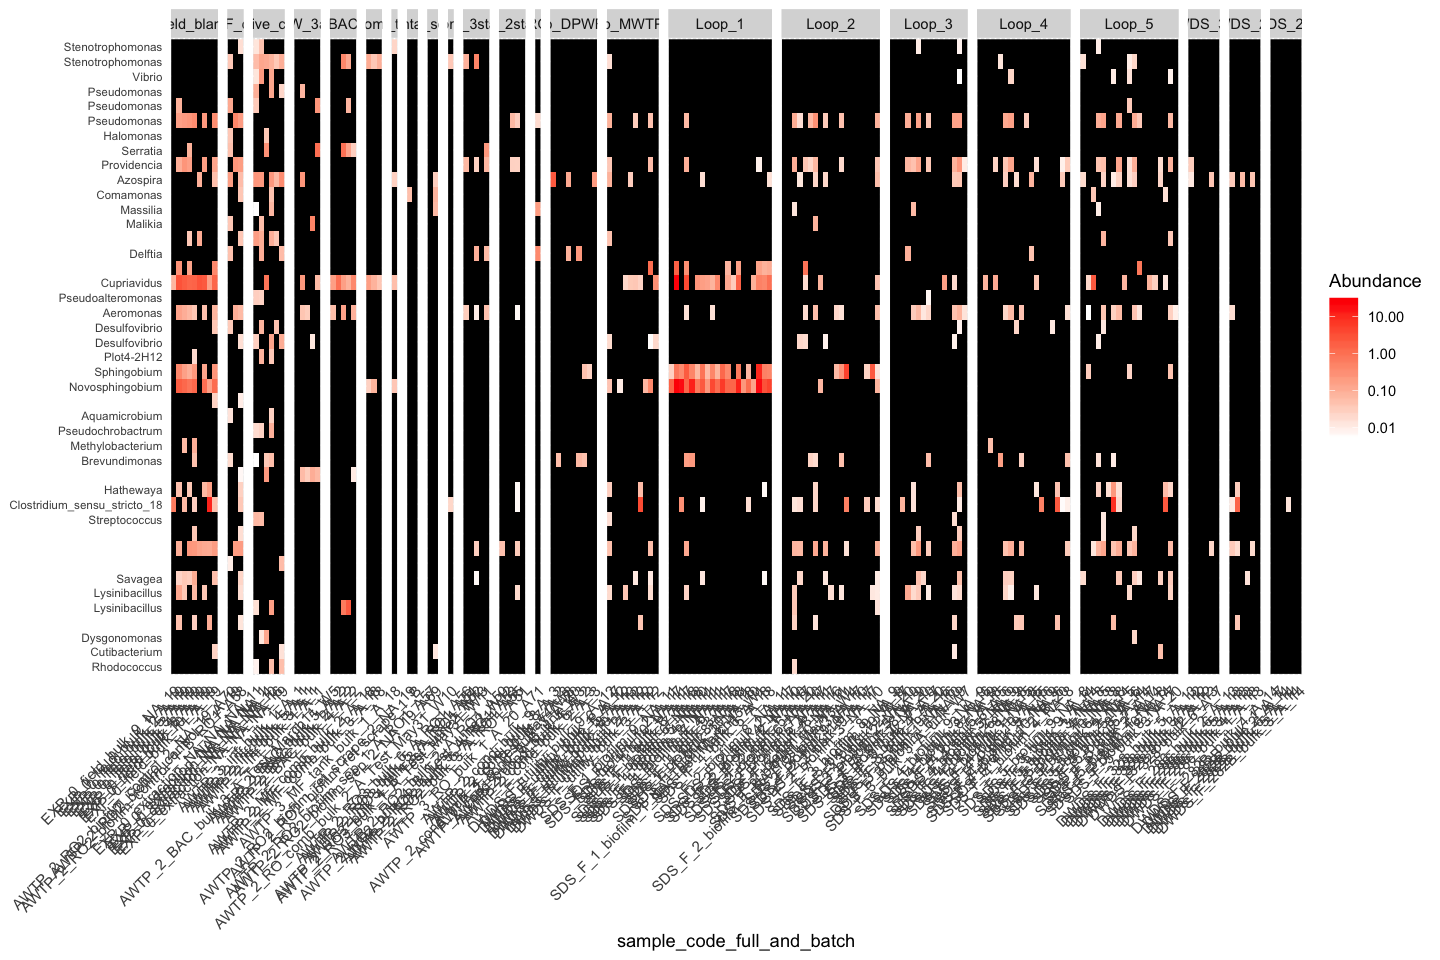

In [376]:
ps_decontam_prev_contams <- prune_taxa(decontam_prev_contams, ps_samp_blank_perc)
sample_data(ps_decontam_prev_contams)$location_code <- factor(sample_data(ps_decontam_prev_contams)$location_code, 
                            levels=location_levels)

#plot heatmap
options(repr.plot.width = 12, repr.plot.height = 8)
plot_heatmap(ps_decontam_prev_contams, taxa.label = "Genus", sample.label = "sample_code_full_and_batch", sample.order = "location_code", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~location_code, scale="free_x", space="free_x")
ggsave('~/data/awtp2_16S/heatmap_decontam_prev_contams.png', device='png', width=20, height=9)

**Based on visualization, the decontam prevalence method has missed some of the high-abundance contaminants seen in the initial analyses of intersecting blanks-and-samples taxa.**

**Prevalence won't work perfectly because it will miss contaminants that are present in ALL samples.**

## DESeq2 method

In [453]:
#Define low biomass samples
ps_samp_blank.lowBM <- subset_samples(ps_samp_blank, subset = !(location_code %in% c("WW_3ary",
                                                                                     "BAC",
                                                                                     "RO_BF_retentate_scrapings",
                                                                                     "MF_tank",
                                                                                     "MF_combined",
                                                                                     "Loop_DPWF_inf")))

In [427]:
sample_data(ps_samp_blank)$sample_or_control <- factor(sample_data(ps_samp_blank)$sample_or_control, levels=c("control", "sample"))

In [454]:
#run DESeq on the bulk and blank taxa
# following: https://bioconductor.org/packages/devel/bioc/vignettes/phyloseq/inst/doc/phyloseq-mixture-models.html

diagdds = phyloseq_to_deseq2(ps_samp_blank.lowBM, ~ sample_or_control) # types are "sample" for controls and "control" for samples

# calculate geometric means prior to estimate size factors
gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}
geoMeans = apply(counts(diagdds), 1, gm_mean)
diagdds = estimateSizeFactors(diagdds, geoMeans = geoMeans)
diagdds = DESeq(diagdds, fitType="local")

res = results(diagdds)
res = res[order(res$padj, na.last=NA), ]
alpha = 0.01
sigtab = res[(res$padj < alpha), ]
sigtab = cbind(as(sigtab, "data.frame"), as(tax_table(ps_samp_blank)[rownames(sigtab), ], "matrix"))
head(sigtab)

converting counts to integer mode
using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 812 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


baseMean  
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTATGTAAGTCAGATGTGAAATCCCCGGGCTCAACCTGGGAATGGCATTTGAGACTGCATGGCTAGAGTGTGTCAGAGGGGGGTAGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAATACCGATGGCGAAGGCAGCCCCCTGGGATAACACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA   69.15033
AGGGTGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTAGAGTACTGCAGGGGAGGCTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACA   43.05273
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTCAGCAAGTTGGAGGTGAAATCCCCGGGCTCAACCTGGGAACTGCCTCCAAAACTACTGAGCTAGAGTACGGTAGAGGGTAGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACTACCTGGACTGATACTGACACTGAGGTGCGAAAGCGTGGGGAGCAAACA   44.70812
AGGGGGCTAGCGTTGCTCGGAATCACTGGGCGTAAAGGGCGCGTAGGCGGCCATTCAAGTCGGGGGTGAAAGCCTGTGGCTCAACCACAGAATTGCCTTCGATACTGTTTGGCTTGAGACCGGAAGAGGTAAGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCAGTGGCGAAGGCGGCTTACTGGTCCGGTTCTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA 7397.88318
AGGGGGCTAGCGTTGTTCGGAATCACTGGGCGTAAAGCGCACGTAGGCGGACCGTTAAGTCGGAGGTGAAAGCCTGGGGCTCAACCCCAGAACTGCCTTCGATACTGGCGGTCTTGAGTATGGTAGAGGTTGGTGGAACTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGGCCAACTGGACCATTACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACA   16.71032
AGGGTGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTAGAGTACTGCAGGGGAGACTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACA 2382.09431
                                                                                                                                                                                                                                                       log2FoldChange
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTATGTAAGTCAGATGTGAAATCCCCGGGCTCAACCTGGGAATGGCATTTGAGACTGCATGGCTAGAGTGTGTCAGAGGGGGGTAGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAATACCGATGGCGAAGGCAGCCCCCTGGGATAACACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA 24.310252     
AGGGTGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTAGAGTACTGCAGGGGAGGCTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACA 23.634817     
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTCAGCAAGTTGGAGGTGAAATCCCCGGGCTCAACCTGGGAACTGCCTCCAAAACTACTGAGCTAGAGTACGGTAGAGGGTAGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACTACCTGGACTGATACTGACACTGAGGTGCGAAAGCGTGGGGAGCAAACA 20.871227     
AGGGGGCTAGCGTTGCTCGGAATCACTGGGCGTAAAGGGCGCGTAGGCGGCCATTCAAGTCGGGGGTGAAAGCCTGTGGCTCAACCACAGAATTGCCTTCGATACTGTTTGGCTTGAGACCGGAAGAGGTAAGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCAGTGGCGAAGGCGGCTTACTGGTCCGGTTCTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA  8.288589     
AGGGGGCTAGCGTTGTTCGGAATCACTGGGCGTAAAGCGCACGTAGGCGGACCGTTAAGTCGGAGGTGAAAGCCTGGGGCTCAACCCCAGAACTGCCTTCGATACTGGCGGTCTTGAGTATGGTAGAGGTTGGTGGAACTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGGCCAACTGGACCATTACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACA 22.297799     
AGGGTGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTAGAGTACTGCAGGGGAGACTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACA  8.589952     
                                                                                                                                                                                                                                                       lfcSE    
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTATGTAAGTCAGATGTGAAATCCCCGGGCTCAACCTGGGAATGGCATTTGAGACTGCATGGCTAGAGTGTGTCAGAGGGGGGTAGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAATACCGATGGCGAAGGCAGCCCCCTGGGATAACACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA 1.4603774
AGGGTGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAAACTCACAGCTTAACTGTGGGCG

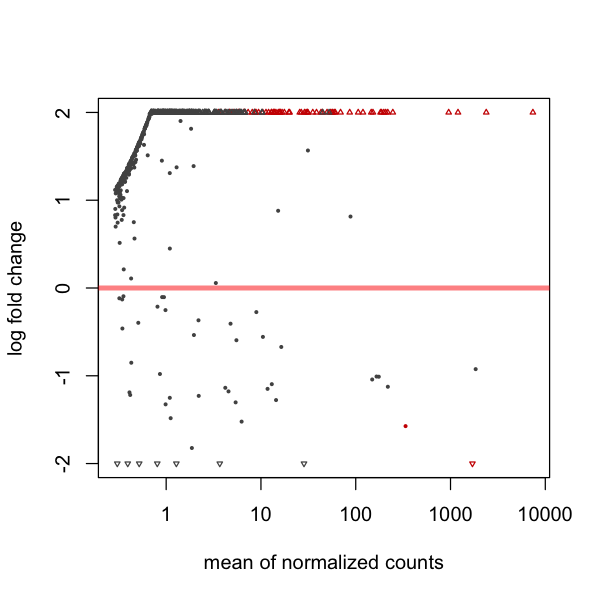

In [455]:
#plot deseq results
options(repr.plot.width = 5, repr.plot.height = 5)
plotMA(res, ylim=c(-2,2))

In [456]:
restab = cbind(as(res, "data.frame"), as(tax_table(ps_samp_blank)[rownames(res), ], "matrix"))
restab[restab$log2FoldChange < 0,]

baseMean    
AGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTTTGTTAAGTCTGATGTGAAAGCCCTGGGCTCAACCTGGGAATGGCATTGGAAACTGGCTTACTAGAGTGCGGTAGAGGGTAGCGGAATTCCCGGTGTAGCAGTGAAATGCGTAGATATCGGGAGGAACATCCGTGGCGAAGGCGGCTACCTGGACCAGCACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA 1703.4367510
AGGTGGCAAGCGTTGTCCGGATTTACTGGGCGTAAAGGGTGCGTAGGCGGATGCTTAAGTGAGATGTGAAATACCTAGGCTTAACTTAGGGGCTGCATTTCAAACTGGGCATCTAGAGTACAGGAGAGGGAAACGGAATTCCTAGTGTAGCGGTGAAATGCGTAGAGATTAGGAAGAACACCAGTGGCGAAGGCGGTTTCCTGGACTGTAACTGACGCTGAGGCACGAAAGCGTGGGTAGCAAACA  335.5381969
AGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTTCGTAAGACAGACGTGAAATCCCCGGGCTCAACCTGGGAACTGCGTTTGTGACTGCGAGGCTAGAGTACGGCAGAGGGGGGTAGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAATACCGATGGCGAAGGCAGCCCCCTGGGTTAGTACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA    3.6785285
AGGGGGCGAGCGTTGTCCGGAATTACTGGGTGTAAAGGGTGCGTAGGCGGCCTTGCAAGTCAGATGTGAAAGATCACGGCTTAACTGTGGTAAGCATTTGAAACTGTAAGGCTTGAGTGCAGGAGAGGAGAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAAGAATATCAGTGGCGAAGGCGGCTCTCTGGACTGCAACTGACGCTGAGGCACGAAAGCGTGGGGAGCAAACAG  218.1889775
AGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTCGTTTAAGTCCGTTGTGAAAGCCCTGGGCTCAACCTGGGAACTGCAGTGGATACTGGGCGACTAGAGTGTGGTAGAGGGTAGCGGAATTCCTGGTGTAGCAGTGAAATGCGTAGAGATCAGGAGGAACATCCATGGCGAAGGCAGCTACCTGGACCAACACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA    0.8057157
AGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTTTGTAAGACAGAGGTGAAATCCCCGGGCTCAACCTGGGAACTGCCTTTGTGACTGCAAAGCTGGAGTGCGGCAGAGGGGGATGGAATTCCGCGTGTAGCAGTGAAATGCGTAGATATGCGGAGGAACACCGATGGCGAAGGCAATCCCCTGGGCCTGCACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA    1.2806483
AGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTTTGTAAGACAGGCGTGAAATCCCCGGGCTCAACCTGGGAATTGCGCTTGTGACTGCAAGGCTAGAGTGCGTCAGAGGGGGGTAGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAATACCGATGGCGAAGGCAGCCCCCTGGGACGTGACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA   28.4602113
AGGGGGCTAGCGTTATCCGGATTTACTGGGCGTAAAGGGTGCGTAGGCGGTCTTTCAAGTCAGGAGTGAAAGGCTACGGCTCAACCGTAGTAAGCTCTTGAAACTGGGAGACTTGAGTGCAGGAGAGGAGAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTAGCGAAGGCGGCTCTCTGGACTGTAACTGACGCTGAGGCACGAAAGCGTGGGGAGCGAACAG 1842.1809947
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCAATTAAGTCAGATGTGAAAGCCCCGAGCTTAACTTGGGAATTGCATCTGAAACTGGTTGGCTAGAGTCTTGTAGAGGGGGGTAGAATTCCATGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACA   14.4305648
AGGGGGCTAGCGTTATCCGGATTTACTGGGCGTAAAGGGTGCGTAGGCGGTCTTTCAAGTCAGGAGTGAAAGGCTACGGCTCAACCGTAGTAAGCTCTTGAAACTGGGAGACTTGAGTGCAGGAGAGGAGAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAATACCAGTAGCGAAGGCGGCTCTCTGGACTGTAACTGACGCTGAGGCACGAAAGCGTGGGGAGCGAACAG  175.1229525
AGGGGGCTAGCGTTATCCGGATTTACTGGGCGTAAAGGGTGCGTAGGCGGTCTTTCAAGTCAGGAGTGAAAGGCTACGGCTCAACCGTAGTAAGCTTTTGAAACTGGGAGACTTGAGTGCAGGAGAGGAGAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTAGCGAAGGCGGCTCTCTGGACTGTAACTGACGCTGAGGCACGAAAGCGTGGGGAGCGAACAG  165.7683358
AGGGGGCTAGCGTTATCCGGATTTACTGGGCGTAAAGGGTGCGTAGGCGGTTTTTCAAGTCAGGAGTGAAAGGCTACGGCTCAACCGTAGTAAGCTCTTGAAACTGGGAGACTTGAGTGCAGGAGAGGAGAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTAGCGAAGGCGGCTCTCTGGACTGTAACTGACGCTGAGGCACGAAAGCGTGGGGAGCGAACAG  149.1575420
AGGTGGCGAGCGTTGTCCGGATTTACTGGGCGTAAAGGGTGCGTAGGCGGATGTTTAAGTGGGATGTGAAATCCCCGGGCTTAACCTGGGGGCTGCATTCCAAACTGGATATCTAGAGTGCAGGAGAGGAAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGAGATTAGGAAGAACACCAGTGGCGAAGGCGGCTTTCTGGACTGTAACTGACGCTGAGGCACGAAAGCGTGGGTAGCAAACA   10.4882846
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTCGAAACTGGCAGGCTAGAGTCTTGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACA    8.9404408
AGGGGGCGAGCGTTGTCCGGAATTACTGGGTGTAAAGGGCATGTAGGCGGGGATGCAAGTCGTCGGTAAAAACCCGCAGCTCAACTACGGGCTTGCCGGCGAAACTGTATCTCTTGAGTGCAGGAGAGGGAAGTGGAATTTCCGGAGTAGCGGTGAAATGCGTAGATACCGGAAAGAACACCAGTGGCGAAGGCGGCTTCCTATTCTGCAACTGACGCTCAGATGCGAAAGCTAGGGTAGCGAACG   16.3866678
AGGGTGCGAGCGTTAATCGGATTTACTGGGCGTAAAGCGTGCGTAGGCGGCTTATTAAGTCGGATGTGAAATCCCCGAGCTTAACTT

In [457]:
alpha = 0.01
sigtab = res[(res$padj < alpha), ]
sigtab = cbind(as(sigtab, "data.frame"), as(tax_table(ps_samp_blank)[rownames(sigtab), ], "matrix"))
head(sigtab)

baseMean  
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTATGTAAGTCAGATGTGAAATCCCCGGGCTCAACCTGGGAATGGCATTTGAGACTGCATGGCTAGAGTGTGTCAGAGGGGGGTAGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAATACCGATGGCGAAGGCAGCCCCCTGGGATAACACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA   69.15033
AGGGTGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTAGAGTACTGCAGGGGAGGCTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACA   43.05273
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTCAGCAAGTTGGAGGTGAAATCCCCGGGCTCAACCTGGGAACTGCCTCCAAAACTACTGAGCTAGAGTACGGTAGAGGGTAGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACTACCTGGACTGATACTGACACTGAGGTGCGAAAGCGTGGGGAGCAAACA   44.70812
AGGGGGCTAGCGTTGCTCGGAATCACTGGGCGTAAAGGGCGCGTAGGCGGCCATTCAAGTCGGGGGTGAAAGCCTGTGGCTCAACCACAGAATTGCCTTCGATACTGTTTGGCTTGAGACCGGAAGAGGTAAGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCAGTGGCGAAGGCGGCTTACTGGTCCGGTTCTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA 7397.88318
AGGGGGCTAGCGTTGTTCGGAATCACTGGGCGTAAAGCGCACGTAGGCGGACCGTTAAGTCGGAGGTGAAAGCCTGGGGCTCAACCCCAGAACTGCCTTCGATACTGGCGGTCTTGAGTATGGTAGAGGTTGGTGGAACTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGGCCAACTGGACCATTACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACA   16.71032
AGGGTGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTAGAGTACTGCAGGGGAGACTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACA 2382.09431
                                                                                                                                                                                                                                                       log2FoldChange
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTATGTAAGTCAGATGTGAAATCCCCGGGCTCAACCTGGGAATGGCATTTGAGACTGCATGGCTAGAGTGTGTCAGAGGGGGGTAGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAATACCGATGGCGAAGGCAGCCCCCTGGGATAACACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA 24.310252     
AGGGTGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTAGAGTACTGCAGGGGAGGCTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACA 23.634817     
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTCAGCAAGTTGGAGGTGAAATCCCCGGGCTCAACCTGGGAACTGCCTCCAAAACTACTGAGCTAGAGTACGGTAGAGGGTAGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACTACCTGGACTGATACTGACACTGAGGTGCGAAAGCGTGGGGAGCAAACA 20.871227     
AGGGGGCTAGCGTTGCTCGGAATCACTGGGCGTAAAGGGCGCGTAGGCGGCCATTCAAGTCGGGGGTGAAAGCCTGTGGCTCAACCACAGAATTGCCTTCGATACTGTTTGGCTTGAGACCGGAAGAGGTAAGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCAGTGGCGAAGGCGGCTTACTGGTCCGGTTCTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA  8.288589     
AGGGGGCTAGCGTTGTTCGGAATCACTGGGCGTAAAGCGCACGTAGGCGGACCGTTAAGTCGGAGGTGAAAGCCTGGGGCTCAACCCCAGAACTGCCTTCGATACTGGCGGTCTTGAGTATGGTAGAGGTTGGTGGAACTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGGCCAACTGGACCATTACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACA 22.297799     
AGGGTGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTAGAGTACTGCAGGGGAGACTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACA  8.589952     
                                                                                                                                                                                                                                                       lfcSE    
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTATGTAAGTCAGATGTGAAATCCCCGGGCTCAACCTGGGAATGGCATTTGAGACTGCATGGCTAGAGTGTGTCAGAGGGGGGTAGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAATACCGATGGCGAAGGCAGCCCCCTGGGATAACACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA 1.4603774
AGGGTGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAAACTCACAGCTTAACTGTGGGCG

In [432]:
#Enriched in samples
posigtab = sigtab[sigtab[, "log2FoldChange"] > 0, ]
posigtab = posigtab[, c("baseMean", "log2FoldChange", "lfcSE", "padj", "Phylum", "Class", "Family", "Genus")]
posigtab

baseMean   
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTCAGCAAGTTGGAGGTGAAATCCCCGGGCTCAACCTGGGAACTGCCTCCAAAACTACTGAGCTAGAGTACGGTAGAGGGTAGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACTACCTGGACTGATACTGACACTGAGGTGCGAAAGCGTGGGGAGCAAACA   44.215818
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTATGTAAGTCAGATGTGAAATCCCCGGGCTCAACCTGGGAATGGCATTTGAGACTGCATGGCTAGAGTGTGTCAGAGGGGGGTAGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAATACCGATGGCGAAGGCAGCCCCCTGGGATAACACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA   74.898705
AGGGTGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTAGAGTACTGCAGGGGAGGCTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACA   39.542126
AGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTTTGTAAGACAGGCGTGAAATCCCCGGGCTCAACCTGGGAACTGCGCTTGTGACTGCAAAGCTAGAGTACGGCAGAGGGGGGTGGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAACACCAATGGCGAAGGCAGCCCCCTGGGTCGATACTGACGCTCATGCACGAAAGCGTGGGTAGCAAACA   18.374109
AGGGGGCTAGCGTTGTTCGGAATCACTGGGCGTAAAGCGCACGTAGGCGGACCGTTAAGTCGGAGGTGAAAGCCTGGGGCTCAACCCCAGAACTGCCTTCGATACTGGCGGTCTTGAGTATGGTAGAGGTTGGTGGAACTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGGCCAACTGGACCATTACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACA   15.878880
AGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGCTTTGCAAGACAGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTTGTGACTGCAAGGCTAGAGTACGGCAGAGGGGGATGGAATTCCGCGTGTAGCAGTGAAATGCGTAGATATGCGGAGGAACACCGATGGCGAAGGCAATCCCCTGGGCCTGTACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA   27.886897
AGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTATATAAGACAGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTTGTGACTGTATAGCTAGAGTACGGCAGAGGGGGATGGAATTCCGCGTGTAGCAGTGAAATGCGTAGATATGCGGAGGAACACCGATGGCGAAGGCAATCCCCTGGGCCTGTACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA   26.775647
AGGGGGCTAGCGTTGCTCGGAATCACTGGGCGTAAAGGGTGCGTAGGCGGGTCTTTAAGTCAGAGGTGAAATCCTGGAGCTCAACTCCAGAACTGCCTTTGATACTGAGGATCTTGAGTTCGGGAGAGGTGAGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCAGTGGCGAAGGCGGCTCACTGGCCCGATACTGACGCTGAGGCACGAAAGCGTGGGGAGCAAACA   15.570190
AGGGTGCAGGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTCTGTTAAGACAGGTGTGAAATCCCCGAGCTCAACTTGGGAATTGCGCTTGTAACTGGCAGGCTAGAGTGTGGCAGAGGGGGGTGGAATTCCACGTGTAGCAGTGAAATGCGTAGATATGTGGAGGAACACCGATGGCGAAGGCAGCCCCCTGGGTTAACACTGACGCTCAGGCACGAAAGCGTGGGGAGCAAACA   14.240118
AGGGTCCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTGGAGTACTGCAGGGGAGACTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACA   15.653665
AGGGGGCTAGCGTTGCTCGGAATCACTGGGCGTAAAGGGCGCGTAGGCGGCCATTCAAGTCGGGGGTGAAAGCCTGTGGCTCAACCACAGAATTGCCTTCGATACTGTTTGGCTTGAGACCGGAAGAGGTAAGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCAGTGGCGAAGGCGGCTTACTGGTCCGGTTCTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA 6826.138266
AGGGTGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTAGAGTACTGCAGGGGAGACTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACA 2148.051691
AGGGTGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTAGAGTACTGCAGGGGAGACTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAGCGAAAGCGTGGGTAGCGAACA   24.618379
AGGGTGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAATCTCACGGCTTAACTGTGAGCGTGCGGGCGATACGGGCAGACTTGAGTACTGCAGGGGAGACTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACA  886.393910
AGGGGGCTAGCGTTGCTCGGAATCACTGGGCGTAAAGGGCGCGTAGGCGGCGTTTTAAGTCGGGGGTGAAAGCCTGTGGCTCAACCACAGAATGGCCTTCGATACTGGGACGCTTGAGTATGGTAGAGGTTGGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCGGTGGCGAAGGCGGCCAACTGGACCATTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA   51.461333
AGGGGGCTAGCGTTGCTCGGAATCACTGGGCGTAAAGGGTGCGTAGGCGGGTCTTTAAGTCAGGGGTGAAATCCTGGAGCTCAACTCCAGAACTGCCTTTGAT

In [458]:
#Enriched in negative controls
negsigtab = sigtab[sigtab[, "log2FoldChange"] < 0, ]
negsigtab = negsigtab[, c("baseMean", "log2FoldChange", "lfcSE", "padj", "Phylum", "Class", "Family", "Genus")]
negsigtab

baseMean
AGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTTTGTTAAGTCTGATGTGAAAGCCCTGGGCTCAACCTGGGAATGGCATTGGAAACTGGCTTACTAGAGTGCGGTAGAGGGTAGCGGAATTCCCGGTGTAGCAGTGAAATGCGTAGATATCGGGAGGAACATCCGTGGCGAAGGCGGCTACCTGGACCAGCACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA 1703.437
                                                                                                                                                                                                                                                       log2FoldChange
AGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTTTGTTAAGTCTGATGTGAAAGCCCTGGGCTCAACCTGGGAATGGCATTGGAAACTGGCTTACTAGAGTGCGGTAGAGGGTAGCGGAATTCCCGGTGTAGCAGTGAAATGCGTAGATATCGGGAGGAACATCCGTGGCGAAGGCGGCTACCTGGACCAGCACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA -3.115021     
                                                                                                                                                                                                                                                       lfcSE    
AGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTTTGTTAAGTCTGATGTGAAAGCCCTGGGCTCAACCTGGGAATGGCATTGGAAACTGGCTTACTAGAGTGCGGTAGAGGGTAGCGGAATTCCCGGTGTAGCAGTGAAATGCGTAGATATCGGGAGGAACATCCGTGGCGAAGGCGGCTACCTGGACCAGCACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA 0.5248201
                                                                                                                                                                                                                                                       padj        
AGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTTTGTTAAGTCTGATGTGAAAGCCCTGGGCTCAACCTGGGAATGGCATTGGAAACTGGCTTACTAGAGTGCGGTAGAGGGTAGCGGAATTCCCGGTGTAGCAGTGAAATGCGTAGATATCGGGAGGAACATCCGTGGCGAAGGCGGCTACCTGGACCAGCACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA 4.589124e-08
                                                                                                                                                                                                                                                       Phylum        
AGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTTTGTTAAGTCTGATGTGAAAGCCCTGGGCTCAACCTGGGAATGGCATTGGAAACTGGCTTACTAGAGTGCGGTAGAGGGTAGCGGAATTCCCGGTGTAGCAGTGAAATGCGTAGATATCGGGAGGAACATCCGTGGCGAAGGCGGCTACCTGGACCAGCACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA Proteobacteria
                                                                                                                                                                                                                                                       Class              
AGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTTTGTTAAGTCTGATGTGAAAGCCCTGGGCTCAACCTGGGAATGGCATTGGAAACTGGCTTACTAGAGTGCGGTAGAGGGTAGCGGAATTCCCGGTGTAGCAGTGAAATGCGTAGATATCGGGAGGAACATCCGTGGCGAAGGCGGCTACCTGGACCAGCACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA Gammaproteobacteria
                                                                                                                                                                                                                                                       Family          
AGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTTTGTTAAGTCTGATGTGAAAGCCCTGGGCTCAACCTGGGAATGGCATTGGAAACTGGCTTACTAGAGTGCGGTAGAGGGTAGCGGAATTCCCGGTGTAGCAGTGAAATGCGTAGATATCGGGAGGAACATCCGTGGCGAAGGCGGCTACCTGGACCAGCACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA Xanthomonadaceae
                                                                                                                                                                                                                                                       Genus     
AGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTTTGTTAAGTCTGATGTGAAAGCCCTGGGCTCAACCTGGGAATGGCATTGGAAACTGGCTTACTAGAGTGCGGTAGAGGGTAGCGGAATTCCCGGTGTAGCAGTGAAATGCGTAGATATCGGGAGGAACATCCGTGGCGAAGGCGGCTACCTGGACCAGCACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA Lysobacter

**This method found only the single most abundant contaminant.  It missed the clostridiales contaminant(s).**

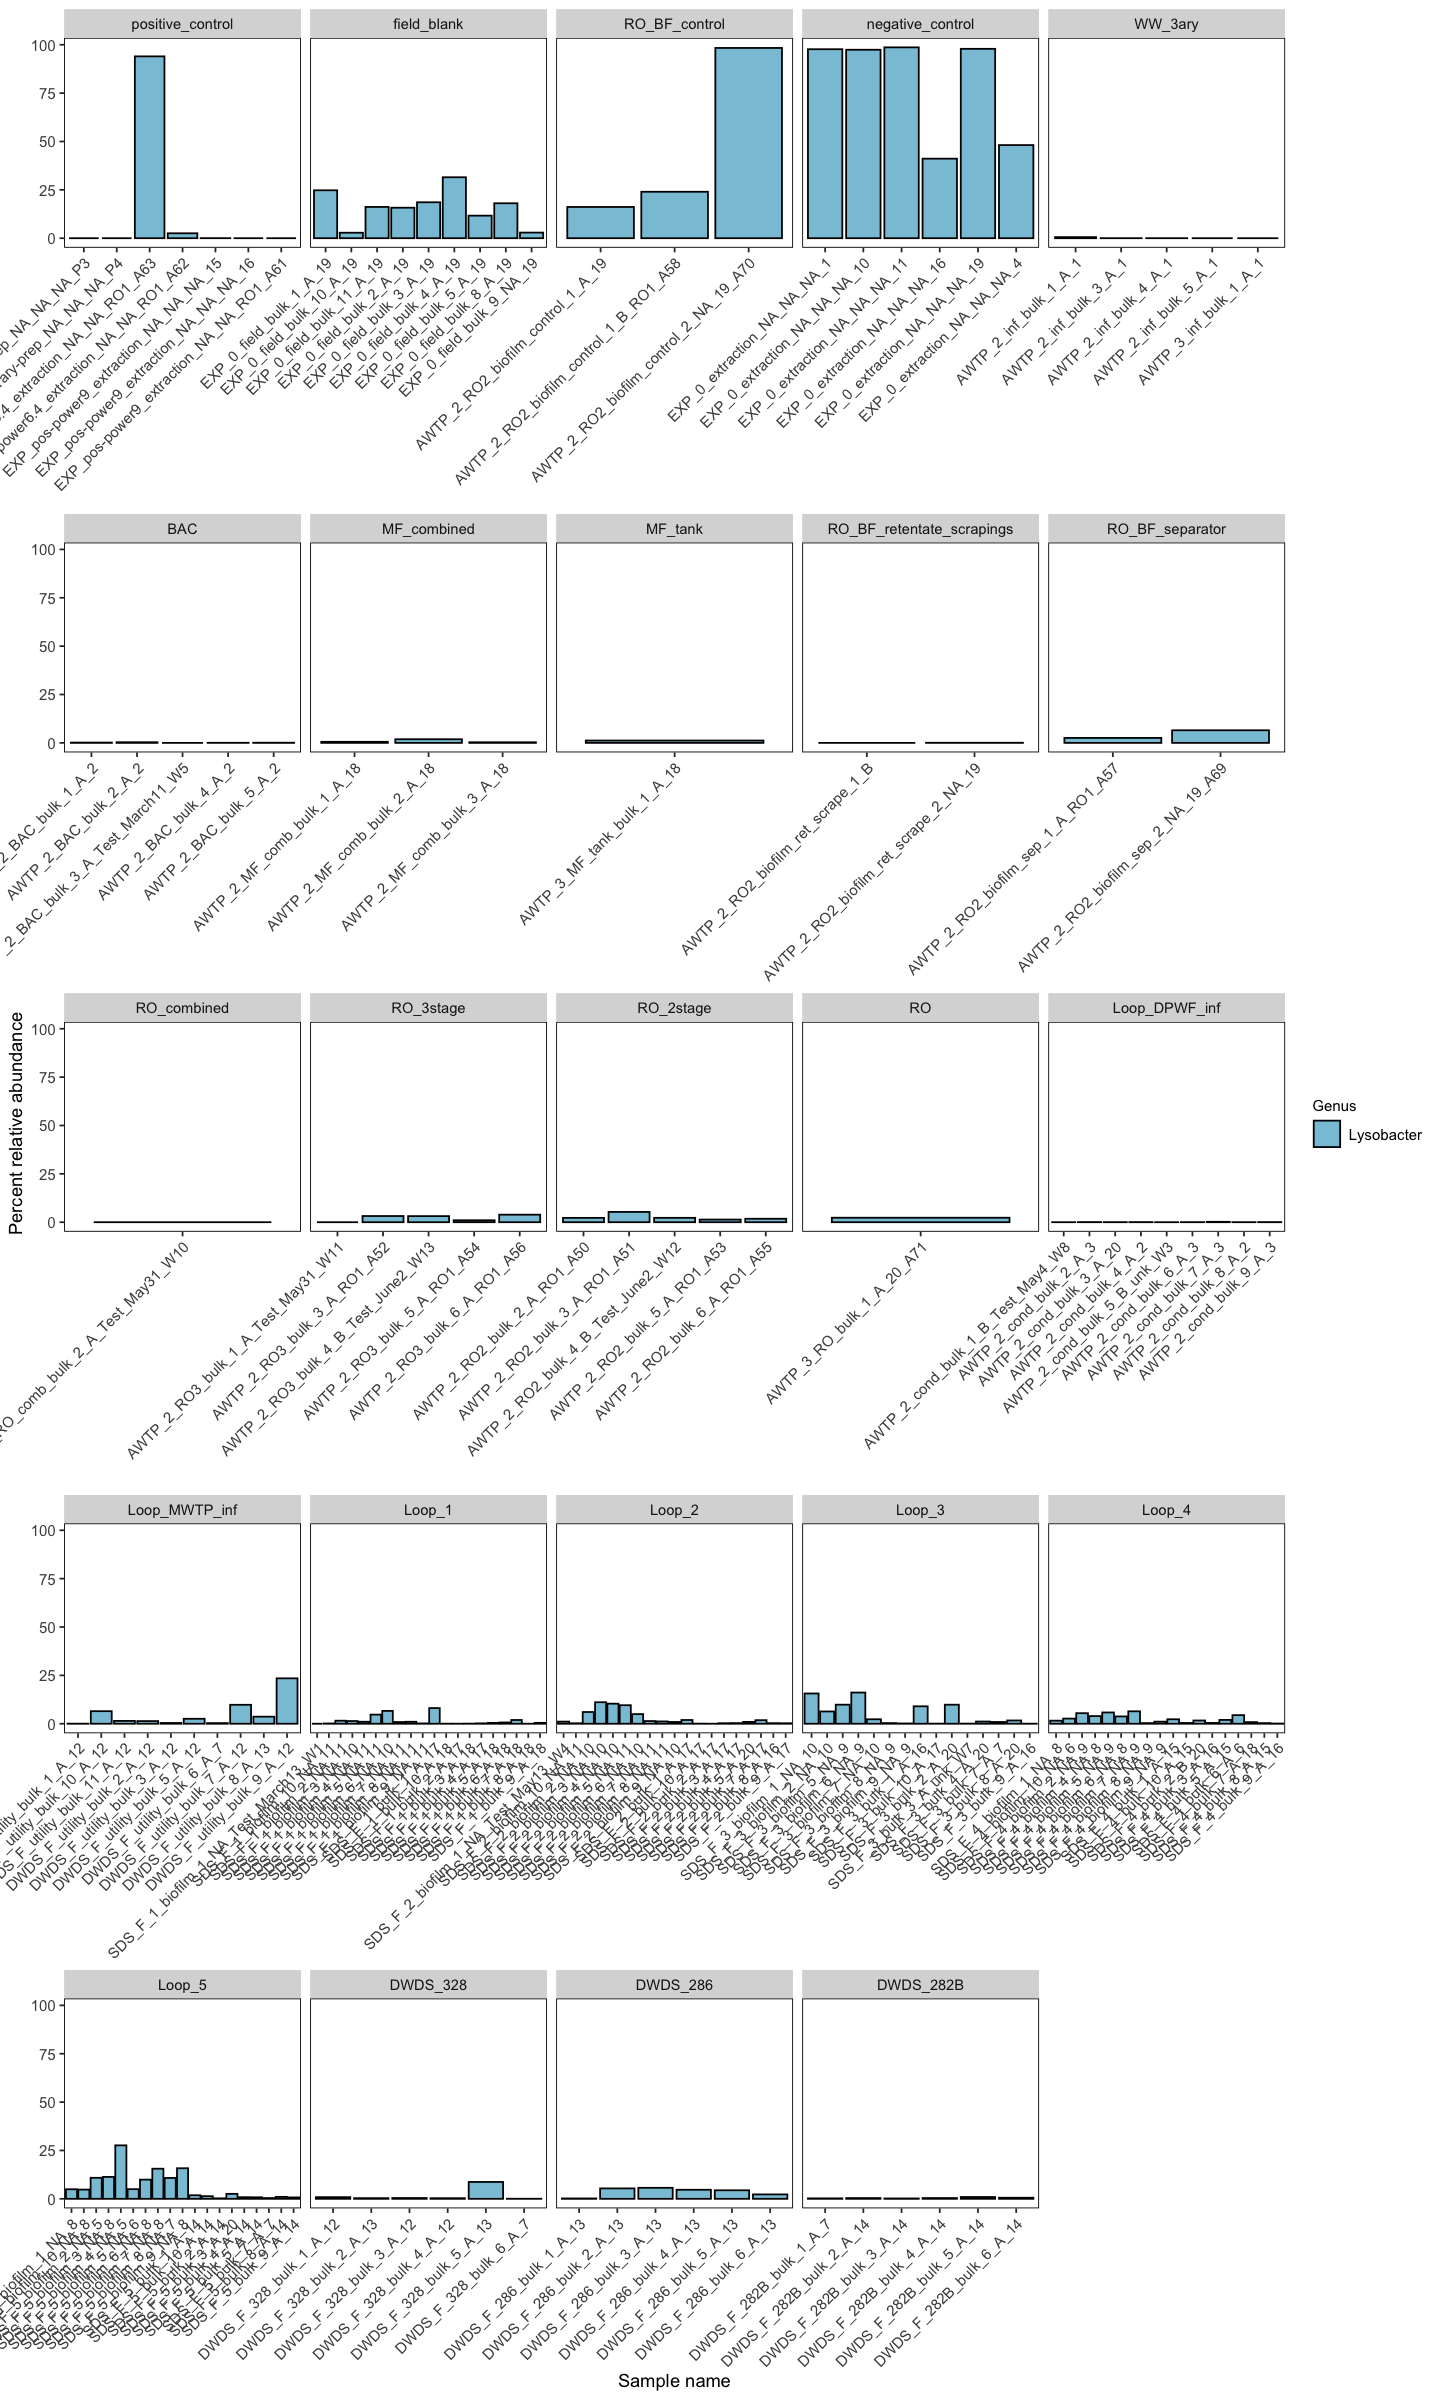

In [297]:
contam1 <- 'AGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTTTGTTAAGTCTGATGTGAAAGCCCTGGGCTCAACCTGGGAATGGCATTGGAAACTGGCTTACTAGAGTGCGGTAGAGGGTAGCGGAATTCCCGGTGTAGCAGTGAAATGCGTAGATATCGGGAGGAACATCCGTGGCGAAGGCGGCTACCTGGACCAGCACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA'
ps_contam1_perc <- prune_taxa(contam1, ps_perc)

options(repr.plot.width = 12, repr.plot.height = 20)
plot_bar(ps_contam1_perc, x="sample_code_full_and_batch", fill="Genus") + scale_fill_manual(values = colors2) + 
  theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9),
        axis.text.y = element_text(size=9),
        legend.text=element_text(size=9), 
        legend.title=element_text(size=9))+
    facet_wrap(~location_code, nrow=5, scale="free_x")+
ylab("Percent relative abundance") +
xlab("Sample name")+
guides(fill=guide_legend(ncol=1))


**Treating all blanks as one sample type led to DESeq2 only identifying a single ASV contaminant.  Let's try sequential decontamination, first with PCR negative controls, then with field blanks.**

## Sequential decontamination with PCR blanks and Field blanks

### PCR blanks

In [387]:
ps_samp_pcrcontrol <- subset_samples(ps_samp_blank, subset = !(location_code %in% c("field_blank", "RO_BF_control")))

#### DESEq2 method

In [388]:
diagdds = phyloseq_to_deseq2(ps_samp_pcrcontrol, ~ sample_or_control) # types are "sample" for controls and "control" for samples

# calculate geometric means prior to estimate size factors
gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}
geoMeans = apply(counts(diagdds), 1, gm_mean)
diagdds = estimateSizeFactors(diagdds, geoMeans = geoMeans)
diagdds = DESeq(diagdds, fitType="local")

res = results(diagdds)
res = res[order(res$padj, na.last=NA), ]
alpha = 0.01
sigtab = res[(res$padj < alpha), ]
sigtab = cbind(as(sigtab, "data.frame"), as(tax_table(ps_samp_blank)[rownames(sigtab), ], "matrix"))

converting counts to integer mode
using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 1635 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [389]:
#Enriched in negative controls
negsigtab = sigtab[sigtab[, "log2FoldChange"] < 0, ]
negsigtab = negsigtab[, c("baseMean", "log2FoldChange", "lfcSE", "padj", "Phylum", "Class", "Family", "Genus")]
pcrcontrol_taxa <- row.names(negsigtab)

In [390]:
negsigtab

baseMean
AGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTTTGTTAAGTCTGATGTGAAAGCCCTGGGCTCAACCTGGGAATGGCATTGGAAACTGGCTTACTAGAGTGCGGTAGAGGGTAGCGGAATTCCCGGTGTAGCAGTGAAATGCGTAGATATCGGGAGGAACATCCGTGGCGAAGGCGGCTACCTGGACCAGCACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA 1513.967
                                                                                                                                                                                                                                                       log2FoldChange
AGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTTTGTTAAGTCTGATGTGAAAGCCCTGGGCTCAACCTGGGAATGGCATTGGAAACTGGCTTACTAGAGTGCGGTAGAGGGTAGCGGAATTCCCGGTGTAGCAGTGAAATGCGTAGATATCGGGAGGAACATCCGTGGCGAAGGCGGCTACCTGGACCAGCACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA -4.540177     
                                                                                                                                                                                                                                                       lfcSE    
AGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTTTGTTAAGTCTGATGTGAAAGCCCTGGGCTCAACCTGGGAATGGCATTGGAAACTGGCTTACTAGAGTGCGGTAGAGGGTAGCGGAATTCCCGGTGTAGCAGTGAAATGCGTAGATATCGGGAGGAACATCCGTGGCGAAGGCGGCTACCTGGACCAGCACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA 0.9725072
                                                                                                                                                                                                                                                       padj        
AGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTTTGTTAAGTCTGATGTGAAAGCCCTGGGCTCAACCTGGGAATGGCATTGGAAACTGGCTTACTAGAGTGCGGTAGAGGGTAGCGGAATTCCCGGTGTAGCAGTGAAATGCGTAGATATCGGGAGGAACATCCGTGGCGAAGGCGGCTACCTGGACCAGCACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA 6.740407e-05
                                                                                                                                                                                                                                                       Phylum        
AGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTTTGTTAAGTCTGATGTGAAAGCCCTGGGCTCAACCTGGGAATGGCATTGGAAACTGGCTTACTAGAGTGCGGTAGAGGGTAGCGGAATTCCCGGTGTAGCAGTGAAATGCGTAGATATCGGGAGGAACATCCGTGGCGAAGGCGGCTACCTGGACCAGCACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA Proteobacteria
                                                                                                                                                                                                                                                       Class              
AGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTTTGTTAAGTCTGATGTGAAAGCCCTGGGCTCAACCTGGGAATGGCATTGGAAACTGGCTTACTAGAGTGCGGTAGAGGGTAGCGGAATTCCCGGTGTAGCAGTGAAATGCGTAGATATCGGGAGGAACATCCGTGGCGAAGGCGGCTACCTGGACCAGCACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA Gammaproteobacteria
                                                                                                                                                                                                                                                       Family          
AGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTTTGTTAAGTCTGATGTGAAAGCCCTGGGCTCAACCTGGGAATGGCATTGGAAACTGGCTTACTAGAGTGCGGTAGAGGGTAGCGGAATTCCCGGTGTAGCAGTGAAATGCGTAGATATCGGGAGGAACATCCGTGGCGAAGGCGGCTACCTGGACCAGCACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA Xanthomonadaceae
                                                                                                                                                                                                                                                       Genus     
AGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTTTGTTAAGTCTGATGTGAAAGCCCTGGGCTCAACCTGGGAATGGCATTGGAAACTGGCTTACTAGAGTGCGGTAGAGGGTAGCGGAATTCCCGGTGTAGCAGTGAAATGCGTAGATATCGGGAGGAACATCCGTGGCGAAGGCGGCTACCTGGACCAGCACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA Lysobacter

In [314]:
#remove contaminants identified by DESeq2 method
allTaxa = taxa_names(ps_samp_blank)
allTaxa_minus_pcrcontrol <- allTaxa[!(allTaxa %in% pcrcontrol_taxa)]

#### Decontam prevalence method

In [396]:
contamdf.prev <- isContaminant(ps_samp_pcrcontrol, method="prevalence", neg="is.neg")
table(contamdf.prev$contaminant)
decontam_prev_contams.pcr <- row.names(contamdf.prev[contamdf.prev$contaminant==TRUE,])


FALSE  TRUE 
 7057    56 

Warning message:
“Transformation introduced infinite values in discrete y-axis”Warning message:
“Transformation introduced infinite values in discrete y-axis”

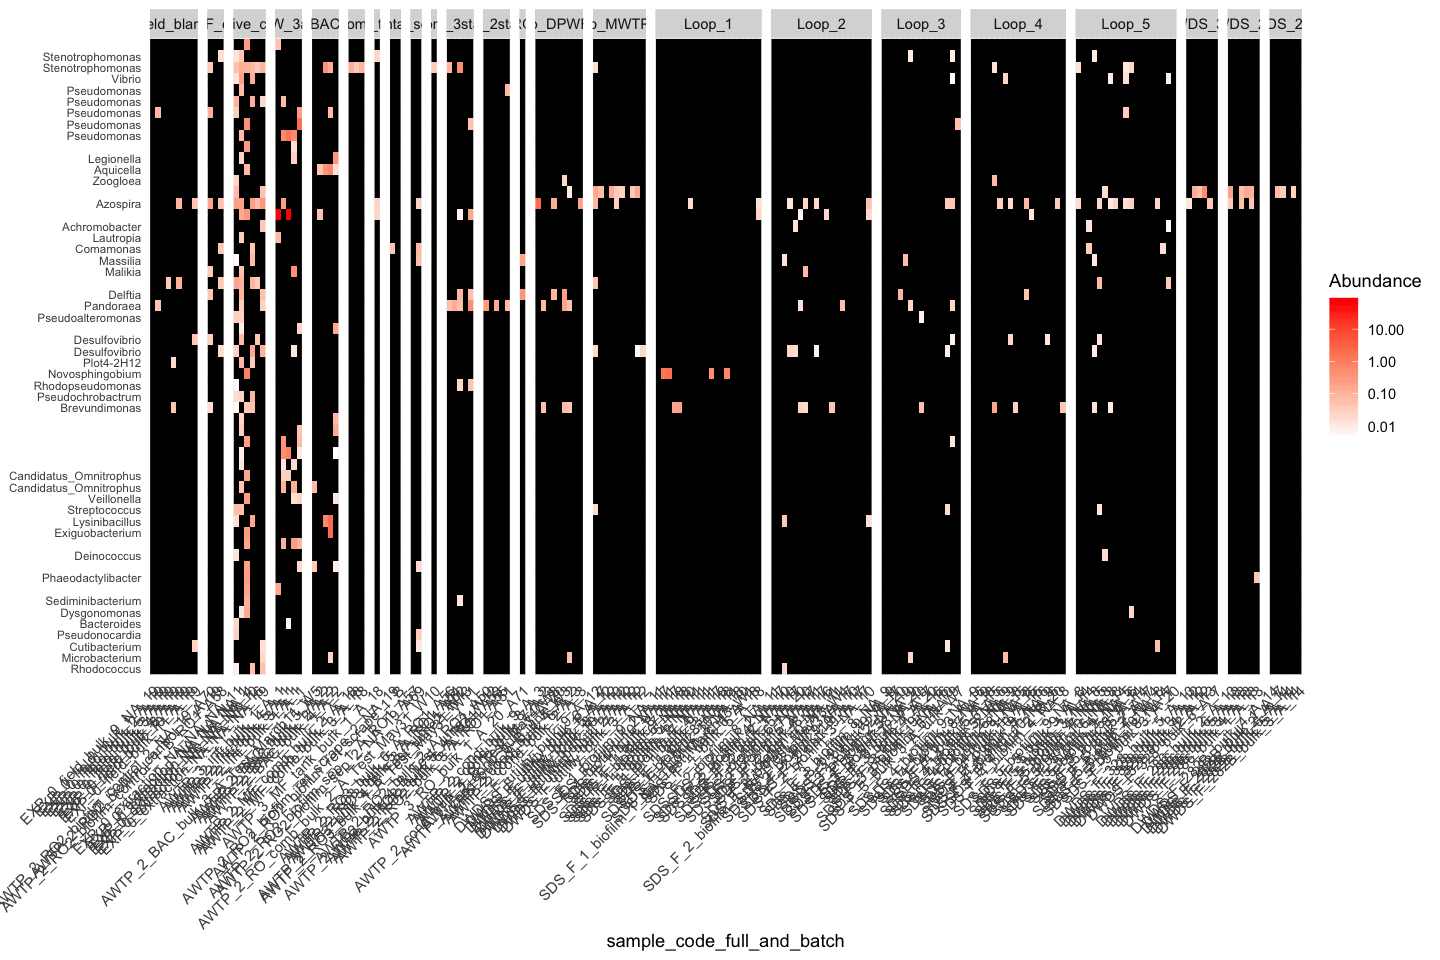

In [398]:
ps_decontam_prev_contams.pcr <- prune_taxa(decontam_prev_contams.pcr, ps_samp_blank_perc)
sample_data(ps_decontam_prev_contams.pcr)$location_code <- factor(sample_data(ps_decontam_prev_contams.pcr)$location_code, 
                            levels=location_levels)

#plot heatmap
options(repr.plot.width = 12, repr.plot.height = 8)
plot_heatmap(ps_decontam_prev_contams.pcr, taxa.label = "Genus", sample.label = "sample_code_full_and_batch", sample.order = "location_code", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~location_code, scale="free_x", space="free_x")
ggsave('~/data/awtp2_16S/heatmap_decontam_prev_contams_pcr.png', device='png', width=20, height=9)

**This method still didn't work well. This makes sense since prevalence doesn't care whether an ASV is more abundant in controls, just that is more prevalent. The pervasive contaminants will be prevalent in every sample group, so prevalence is NOT a good method for identifying these.**

### Field blanks

In [316]:
ps_samp_fieldblank <- subset_samples(ps_samp_blank, subset = !(location_code %in% c("negative_control")))
ps_samp_fieldblank <- prune_taxa(allTaxa_minus_pcrcontrol, ps_samp_fieldblank)
ps_samp_fieldblank

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7122 taxa and 170 samples ]
sample_data() Sample Data:       [ 170 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 7122 taxa by 6 taxonomic ranks ]

In [317]:
diagdds = phyloseq_to_deseq2(ps_samp_fieldblank, ~ sample_or_control) # types are "sample" for controls and "control" for samples

# calculate geometric means prior to estimate size factors
gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}
geoMeans = apply(counts(diagdds), 1, gm_mean)
diagdds = estimateSizeFactors(diagdds, geoMeans = geoMeans)
diagdds = DESeq(diagdds, fitType="local")

res = results(diagdds)
res = res[order(res$padj, na.last=NA), ]
alpha = 0.01
sigtab = res[(res$padj < alpha), ]
sigtab = cbind(as(sigtab, "data.frame"), as(tax_table(ps_samp_blank)[rownames(sigtab), ], "matrix"))

converting counts to integer mode
using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 1628 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [318]:
#Enriched in negative controls
negsigtab = sigtab[sigtab[, "log2FoldChange"] < 0, ]
negsigtab = negsigtab[, c("baseMean", "log2FoldChange", "lfcSE", "padj", "Phylum", "Class", "Family", "Genus")]
fieldblank_taxa <- row.names(negsigtab)

In [319]:
negsigtab

baseMean log2FoldChange lfcSE padj Phylum Class Family Genus

**DESeq2 method didn't find any additional contaminants in the field blanks**